In [49]:
from __future__ import print_function
import argparse
from math import log10
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from model import Net
from model2 import DeepULMNet
from dataset import get_training_set, get_test_set
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from torchsummary import summary

In [50]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Have bigger cells in Jupyter Notebook 
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Hyper-parameters

In [51]:
# Settings and hyperparameters
upscale_factor = 4
batchSize = 16
testBatchSize = 500
nEpochs = 200
lr = 0.001
threads = 0
seed = 123

In [52]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
else:
    device = torch.device("cpu")

# Normalization

### Test to normalize the data (not successful)

In [53]:

# # 0.1171 - 0.2253 07_noisy / 

# transform = transforms.Compose([
#     transforms.Normalize(0.1171, 0.2253)
# ])
# target_transform = transforms.Compose([
#     transforms.Normalize(0.1171, 0.2253)
# ])

In [54]:
# root = 'training_set_numpy/training_set_numpy_07noisy/training_set_32x32_batch_64/'
# root = 'training_set_numpy/training_set_numpy_noisy/training_set_32x32_batch_64/'
# root = 'training_set_numpy/training_set_numpy_no_noise/training_set_32x32_batch_256/'

# train_set = get_training_set(transform=transform, target_transform=None, root = root)
# training_data_loader = DataLoader(dataset=train_set, num_workers=threads, batch_size=len(train_set), shuffle=False)

In [55]:
# data = next(iter(training_data_loader))
# print(data[0].mean(), data[0].std())
# data = next(iter(testing_data_loader))
# print(data[0].mean(), data[0].std())

# Data training selection

In [56]:
root = '../training_set_numpy/training_set_numpy_07noisy/training_set_32x32_batch_64/'
# root = '../training_set_numpy/training_set_numpy_noisy/training_set_32x32_batch_64/'
# root = '../training_set_numpy/training_set_numpy_no_noise/training_set_32x32_batch_256/'

# train_set = get_training_set(transform=transform, target_transform=target_transform, root = root)
train_set = get_training_set(transform=None, target_transform=None, root = root)

# 10000 - 7500 for 07 noise
indices = np.arange(10000)
np.random.shuffle(indices)
training_data_loader = DataLoader(dataset=train_set, num_workers=threads, batch_size=batchSize, shuffle=False, sampler = SubsetRandomSampler(indices[:7500]))
testing_data_loader = DataLoader(dataset=train_set, num_workers=threads, batch_size=testBatchSize, shuffle=False, sampler = SubsetRandomSampler(indices[7500:]))

# Building the model

In [57]:
print('===> Building model')
# model = Net(upscale_factor=upscale_factor)
model = DeepULMNet()
model = model.cuda()
summary(model, input_size = (1,32,32))
print(model)
criterion = nn.MSELoss().cuda()
criterion2 = nn.L1Loss().cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, nEpochs)

===> Building model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
      BatchNorm2d-12          [-1, 128, 16, 16]             256
        LeakyReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-1

# Gaussian Filter

In [58]:
def matlab_style_gauss2D(shape,sigma=1):
    """ 
    2D gaussian filter - should give the same result as:
    MATLAB's fspecial('gaussian',[shape],[sigma]) 
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h.astype('float32')
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h = h*2.0
    h = h.astype('float32')
    return h

In [59]:
psf_heatmap = torch.from_numpy(matlab_style_gauss2D(shape=(7,7),sigma=1))
gfilter = torch.reshape(psf_heatmap, [1, 1, 7, 7])
zero = torch.zeros(batchSize, 1, 128, 128)
amplitude = 15.0
lmd = 0.1
gfilter = gfilter.cuda()

# Training

In [60]:
def train(epoch):
    epoch_loss = 0
    losses = []
    model.train()
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0].float()).cuda(), Variable(batch[1].float()).cuda()
        zero = torch.zeros(target.size()).cuda()
        
        target *= amplitude
        target = F.conv2d(target, gfilter, padding = 3)
        optimizer.zero_grad()
        out = model(input)
        out2 = F.conv2d(out, gfilter, padding = 3)
        loss = criterion(out2, target) + lmd * criterion2(out, zero)
        epoch_loss += loss.item()
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
#         scheduler.step()
        print("===> Epoch[{}]({}/{}): Loss: {:.4f} ".format(epoch, iteration, len(training_data_loader), loss.item()))
    
    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    return losses

# Test

In [61]:
def test():
    with torch.no_grad():
        avg_psnr = 0
        epoch_loss_val = 0
        predictions = []
        losses_val = []
        model.eval()
        for batch in testing_data_loader:
            input, target = Variable(batch[0].float()).cuda(), Variable(batch[1].float()).cuda()
            zero = torch.zeros(target.size())
            zero = zero.cuda()
            
            target *= amplitude
            target = F.conv2d(target, gfilter, padding = 3)
            prediction = model(input)
            prediction2 = F.conv2d(prediction, gfilter, padding = 3)
            loss_val = criterion(prediction2, target) + lmd * criterion2(prediction, zero)
            epoch_loss_val += loss_val.item()
            losses_val.append(loss_val.item())
            psnr = 10 * log10(amplitude / loss_val.item())
            avg_psnr += psnr
        print("===> Avg. PSNR: {:.4f} dB : Avg. Loss: {:.4f} ".format(avg_psnr / len(testing_data_loader), epoch_loss_val / len(testing_data_loader)))
        return losses_val


# Checkpoint

In [62]:
# Function to save the model parameters at each epoch
def checkpoint(epoch):
#     model_out_path = "../trained_models/liu/model_07_noise_5_{}.pth".format(epoch)
    model_out_path = "../trained_models/liu/model_07_noise_9_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

# Run

===> Epoch[1](1/469): Loss: 0.1246 
===> Epoch[1](2/469): Loss: 0.1759 
===> Epoch[1](3/469): Loss: 0.0812 
===> Epoch[1](4/469): Loss: 0.0896 
===> Epoch[1](5/469): Loss: 0.0813 
===> Epoch[1](6/469): Loss: 0.0669 
===> Epoch[1](7/469): Loss: 0.0630 
===> Epoch[1](8/469): Loss: 0.0626 
===> Epoch[1](9/469): Loss: 0.0529 
===> Epoch[1](10/469): Loss: 0.0607 
===> Epoch[1](11/469): Loss: 0.0541 
===> Epoch[1](12/469): Loss: 0.0571 
===> Epoch[1](13/469): Loss: 0.0367 
===> Epoch[1](14/469): Loss: 0.0392 
===> Epoch[1](15/469): Loss: 0.0350 
===> Epoch[1](16/469): Loss: 0.0425 
===> Epoch[1](17/469): Loss: 0.0540 
===> Epoch[1](18/469): Loss: 0.0434 
===> Epoch[1](19/469): Loss: 0.0457 
===> Epoch[1](20/469): Loss: 0.0440 
===> Epoch[1](21/469): Loss: 0.0423 
===> Epoch[1](22/469): Loss: 0.0338 
===> Epoch[1](23/469): Loss: 0.0410 
===> Epoch[1](24/469): Loss: 0.0432 
===> Epoch[1](25/469): Loss: 0.0327 
===> Epoch[1](26/469): Loss: 0.0342 
===> Epoch[1](27/469): Loss: 0.0364 
===> Epoch

===> Epoch[1](220/469): Loss: 0.0158 
===> Epoch[1](221/469): Loss: 0.0242 
===> Epoch[1](222/469): Loss: 0.0205 
===> Epoch[1](223/469): Loss: 0.0173 
===> Epoch[1](224/469): Loss: 0.0238 
===> Epoch[1](225/469): Loss: 0.0162 
===> Epoch[1](226/469): Loss: 0.0210 
===> Epoch[1](227/469): Loss: 0.0165 
===> Epoch[1](228/469): Loss: 0.0119 
===> Epoch[1](229/469): Loss: 0.0184 
===> Epoch[1](230/469): Loss: 0.0168 
===> Epoch[1](231/469): Loss: 0.0128 
===> Epoch[1](232/469): Loss: 0.0149 
===> Epoch[1](233/469): Loss: 0.0215 
===> Epoch[1](234/469): Loss: 0.0277 
===> Epoch[1](235/469): Loss: 0.0202 
===> Epoch[1](236/469): Loss: 0.0179 
===> Epoch[1](237/469): Loss: 0.0229 
===> Epoch[1](238/469): Loss: 0.0137 
===> Epoch[1](239/469): Loss: 0.0259 
===> Epoch[1](240/469): Loss: 0.0221 
===> Epoch[1](241/469): Loss: 0.0180 
===> Epoch[1](242/469): Loss: 0.0222 
===> Epoch[1](243/469): Loss: 0.0239 
===> Epoch[1](244/469): Loss: 0.0172 
===> Epoch[1](245/469): Loss: 0.0119 
===> Epoch[1

===> Epoch[1](438/469): Loss: 0.0187 
===> Epoch[1](439/469): Loss: 0.0209 
===> Epoch[1](440/469): Loss: 0.0195 
===> Epoch[1](441/469): Loss: 0.0169 
===> Epoch[1](442/469): Loss: 0.0151 
===> Epoch[1](443/469): Loss: 0.0146 
===> Epoch[1](444/469): Loss: 0.0178 
===> Epoch[1](445/469): Loss: 0.0117 
===> Epoch[1](446/469): Loss: 0.0155 
===> Epoch[1](447/469): Loss: 0.0212 
===> Epoch[1](448/469): Loss: 0.0104 
===> Epoch[1](449/469): Loss: 0.0147 
===> Epoch[1](450/469): Loss: 0.0192 
===> Epoch[1](451/469): Loss: 0.0156 
===> Epoch[1](452/469): Loss: 0.0187 
===> Epoch[1](453/469): Loss: 0.0116 
===> Epoch[1](454/469): Loss: 0.0148 
===> Epoch[1](455/469): Loss: 0.0130 
===> Epoch[1](456/469): Loss: 0.0202 
===> Epoch[1](457/469): Loss: 0.0155 
===> Epoch[1](458/469): Loss: 0.0176 
===> Epoch[1](459/469): Loss: 0.0221 
===> Epoch[1](460/469): Loss: 0.0138 
===> Epoch[1](461/469): Loss: 0.0131 
===> Epoch[1](462/469): Loss: 0.0124 
===> Epoch[1](463/469): Loss: 0.0207 
===> Epoch[1

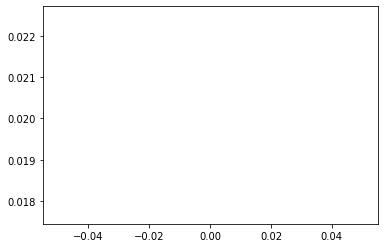

Current learning rate is: 0.001
===> Epoch[2](1/469): Loss: 0.0129 
===> Epoch[2](2/469): Loss: 0.0120 
===> Epoch[2](3/469): Loss: 0.0132 
===> Epoch[2](4/469): Loss: 0.0176 
===> Epoch[2](5/469): Loss: 0.0147 
===> Epoch[2](6/469): Loss: 0.0131 
===> Epoch[2](7/469): Loss: 0.0219 
===> Epoch[2](8/469): Loss: 0.0103 
===> Epoch[2](9/469): Loss: 0.0154 
===> Epoch[2](10/469): Loss: 0.0203 
===> Epoch[2](11/469): Loss: 0.0178 
===> Epoch[2](12/469): Loss: 0.0144 
===> Epoch[2](13/469): Loss: 0.0163 
===> Epoch[2](14/469): Loss: 0.0092 
===> Epoch[2](15/469): Loss: 0.0094 
===> Epoch[2](16/469): Loss: 0.0231 
===> Epoch[2](17/469): Loss: 0.0189 
===> Epoch[2](18/469): Loss: 0.0155 
===> Epoch[2](19/469): Loss: 0.0175 
===> Epoch[2](20/469): Loss: 0.0146 
===> Epoch[2](21/469): Loss: 0.0156 
===> Epoch[2](22/469): Loss: 0.0194 
===> Epoch[2](23/469): Loss: 0.0154 
===> Epoch[2](24/469): Loss: 0.0126 
===> Epoch[2](25/469): Loss: 0.0195 
===> Epoch[2](26/469): Loss: 0.0115 
===> Epoch[2](2

===> Epoch[2](220/469): Loss: 0.0179 
===> Epoch[2](221/469): Loss: 0.0179 
===> Epoch[2](222/469): Loss: 0.0161 
===> Epoch[2](223/469): Loss: 0.0138 
===> Epoch[2](224/469): Loss: 0.0181 
===> Epoch[2](225/469): Loss: 0.0137 
===> Epoch[2](226/469): Loss: 0.0148 
===> Epoch[2](227/469): Loss: 0.0113 
===> Epoch[2](228/469): Loss: 0.0080 
===> Epoch[2](229/469): Loss: 0.0120 
===> Epoch[2](230/469): Loss: 0.0116 
===> Epoch[2](231/469): Loss: 0.0145 
===> Epoch[2](232/469): Loss: 0.0218 
===> Epoch[2](233/469): Loss: 0.0207 
===> Epoch[2](234/469): Loss: 0.0173 
===> Epoch[2](235/469): Loss: 0.0134 
===> Epoch[2](236/469): Loss: 0.0158 
===> Epoch[2](237/469): Loss: 0.0114 
===> Epoch[2](238/469): Loss: 0.0238 
===> Epoch[2](239/469): Loss: 0.0197 
===> Epoch[2](240/469): Loss: 0.0165 
===> Epoch[2](241/469): Loss: 0.0188 
===> Epoch[2](242/469): Loss: 0.0181 
===> Epoch[2](243/469): Loss: 0.0119 
===> Epoch[2](244/469): Loss: 0.0164 
===> Epoch[2](245/469): Loss: 0.0146 
===> Epoch[2

===> Epoch[2](436/469): Loss: 0.0181 
===> Epoch[2](437/469): Loss: 0.0202 
===> Epoch[2](438/469): Loss: 0.0182 
===> Epoch[2](439/469): Loss: 0.0196 
===> Epoch[2](440/469): Loss: 0.0153 
===> Epoch[2](441/469): Loss: 0.0170 
===> Epoch[2](442/469): Loss: 0.0158 
===> Epoch[2](443/469): Loss: 0.0109 
===> Epoch[2](444/469): Loss: 0.0137 
===> Epoch[2](445/469): Loss: 0.0123 
===> Epoch[2](446/469): Loss: 0.0114 
===> Epoch[2](447/469): Loss: 0.0171 
===> Epoch[2](448/469): Loss: 0.0192 
===> Epoch[2](449/469): Loss: 0.0146 
===> Epoch[2](450/469): Loss: 0.0139 
===> Epoch[2](451/469): Loss: 0.0192 
===> Epoch[2](452/469): Loss: 0.0132 
===> Epoch[2](453/469): Loss: 0.0125 
===> Epoch[2](454/469): Loss: 0.0134 
===> Epoch[2](455/469): Loss: 0.0132 
===> Epoch[2](456/469): Loss: 0.0123 
===> Epoch[2](457/469): Loss: 0.0167 
===> Epoch[2](458/469): Loss: 0.0157 
===> Epoch[2](459/469): Loss: 0.0218 
===> Epoch[2](460/469): Loss: 0.0162 
===> Epoch[2](461/469): Loss: 0.0166 
===> Epoch[2

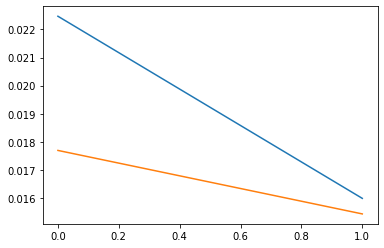

Current learning rate is: 0.001
===> Epoch[3](1/469): Loss: 0.0119 
===> Epoch[3](2/469): Loss: 0.0152 
===> Epoch[3](3/469): Loss: 0.0085 
===> Epoch[3](4/469): Loss: 0.0130 
===> Epoch[3](5/469): Loss: 0.0219 
===> Epoch[3](6/469): Loss: 0.0119 
===> Epoch[3](7/469): Loss: 0.0170 
===> Epoch[3](8/469): Loss: 0.0204 
===> Epoch[3](9/469): Loss: 0.0119 
===> Epoch[3](10/469): Loss: 0.0139 
===> Epoch[3](11/469): Loss: 0.0087 
===> Epoch[3](12/469): Loss: 0.0161 
===> Epoch[3](13/469): Loss: 0.0123 
===> Epoch[3](14/469): Loss: 0.0122 
===> Epoch[3](15/469): Loss: 0.0123 
===> Epoch[3](16/469): Loss: 0.0193 
===> Epoch[3](17/469): Loss: 0.0136 
===> Epoch[3](18/469): Loss: 0.0194 
===> Epoch[3](19/469): Loss: 0.0106 
===> Epoch[3](20/469): Loss: 0.0135 
===> Epoch[3](21/469): Loss: 0.0178 
===> Epoch[3](22/469): Loss: 0.0196 
===> Epoch[3](23/469): Loss: 0.0175 
===> Epoch[3](24/469): Loss: 0.0198 
===> Epoch[3](25/469): Loss: 0.0094 
===> Epoch[3](26/469): Loss: 0.0139 
===> Epoch[3](2

===> Epoch[3](221/469): Loss: 0.0137 
===> Epoch[3](222/469): Loss: 0.0125 
===> Epoch[3](223/469): Loss: 0.0173 
===> Epoch[3](224/469): Loss: 0.0117 
===> Epoch[3](225/469): Loss: 0.0170 
===> Epoch[3](226/469): Loss: 0.0194 
===> Epoch[3](227/469): Loss: 0.0099 
===> Epoch[3](228/469): Loss: 0.0135 
===> Epoch[3](229/469): Loss: 0.0110 
===> Epoch[3](230/469): Loss: 0.0115 
===> Epoch[3](231/469): Loss: 0.0122 
===> Epoch[3](232/469): Loss: 0.0229 
===> Epoch[3](233/469): Loss: 0.0185 
===> Epoch[3](234/469): Loss: 0.0191 
===> Epoch[3](235/469): Loss: 0.0120 
===> Epoch[3](236/469): Loss: 0.0148 
===> Epoch[3](237/469): Loss: 0.0114 
===> Epoch[3](238/469): Loss: 0.0169 
===> Epoch[3](239/469): Loss: 0.0131 
===> Epoch[3](240/469): Loss: 0.0148 
===> Epoch[3](241/469): Loss: 0.0159 
===> Epoch[3](242/469): Loss: 0.0141 
===> Epoch[3](243/469): Loss: 0.0091 
===> Epoch[3](244/469): Loss: 0.0209 
===> Epoch[3](245/469): Loss: 0.0164 
===> Epoch[3](246/469): Loss: 0.0201 
===> Epoch[3

===> Epoch[3](438/469): Loss: 0.0130 
===> Epoch[3](439/469): Loss: 0.0134 
===> Epoch[3](440/469): Loss: 0.0074 
===> Epoch[3](441/469): Loss: 0.0149 
===> Epoch[3](442/469): Loss: 0.0151 
===> Epoch[3](443/469): Loss: 0.0174 
===> Epoch[3](444/469): Loss: 0.0105 
===> Epoch[3](445/469): Loss: 0.0135 
===> Epoch[3](446/469): Loss: 0.0135 
===> Epoch[3](447/469): Loss: 0.0200 
===> Epoch[3](448/469): Loss: 0.0089 
===> Epoch[3](449/469): Loss: 0.0085 
===> Epoch[3](450/469): Loss: 0.0178 
===> Epoch[3](451/469): Loss: 0.0123 
===> Epoch[3](452/469): Loss: 0.0087 
===> Epoch[3](453/469): Loss: 0.0159 
===> Epoch[3](454/469): Loss: 0.0133 
===> Epoch[3](455/469): Loss: 0.0176 
===> Epoch[3](456/469): Loss: 0.0145 
===> Epoch[3](457/469): Loss: 0.0213 
===> Epoch[3](458/469): Loss: 0.0168 
===> Epoch[3](459/469): Loss: 0.0136 
===> Epoch[3](460/469): Loss: 0.0082 
===> Epoch[3](461/469): Loss: 0.0135 
===> Epoch[3](462/469): Loss: 0.0140 
===> Epoch[3](463/469): Loss: 0.0206 
===> Epoch[3

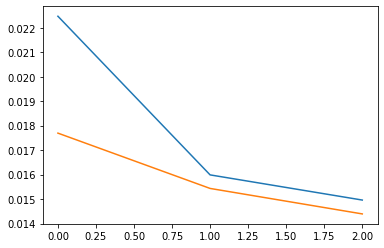

Current learning rate is: 0.001
===> Epoch[4](1/469): Loss: 0.0144 
===> Epoch[4](2/469): Loss: 0.0071 
===> Epoch[4](3/469): Loss: 0.0172 
===> Epoch[4](4/469): Loss: 0.0176 
===> Epoch[4](5/469): Loss: 0.0097 
===> Epoch[4](6/469): Loss: 0.0132 
===> Epoch[4](7/469): Loss: 0.0158 
===> Epoch[4](8/469): Loss: 0.0149 
===> Epoch[4](9/469): Loss: 0.0143 
===> Epoch[4](10/469): Loss: 0.0138 
===> Epoch[4](11/469): Loss: 0.0154 
===> Epoch[4](12/469): Loss: 0.0111 
===> Epoch[4](13/469): Loss: 0.0124 
===> Epoch[4](14/469): Loss: 0.0112 
===> Epoch[4](15/469): Loss: 0.0067 
===> Epoch[4](16/469): Loss: 0.0167 
===> Epoch[4](17/469): Loss: 0.0094 
===> Epoch[4](18/469): Loss: 0.0145 
===> Epoch[4](19/469): Loss: 0.0158 
===> Epoch[4](20/469): Loss: 0.0111 
===> Epoch[4](21/469): Loss: 0.0144 
===> Epoch[4](22/469): Loss: 0.0117 
===> Epoch[4](23/469): Loss: 0.0127 
===> Epoch[4](24/469): Loss: 0.0156 
===> Epoch[4](25/469): Loss: 0.0107 
===> Epoch[4](26/469): Loss: 0.0147 
===> Epoch[4](2

===> Epoch[4](220/469): Loss: 0.0162 
===> Epoch[4](221/469): Loss: 0.0221 
===> Epoch[4](222/469): Loss: 0.0123 
===> Epoch[4](223/469): Loss: 0.0180 
===> Epoch[4](224/469): Loss: 0.0151 
===> Epoch[4](225/469): Loss: 0.0146 
===> Epoch[4](226/469): Loss: 0.0126 
===> Epoch[4](227/469): Loss: 0.0104 
===> Epoch[4](228/469): Loss: 0.0121 
===> Epoch[4](229/469): Loss: 0.0140 
===> Epoch[4](230/469): Loss: 0.0101 
===> Epoch[4](231/469): Loss: 0.0104 
===> Epoch[4](232/469): Loss: 0.0194 
===> Epoch[4](233/469): Loss: 0.0165 
===> Epoch[4](234/469): Loss: 0.0162 
===> Epoch[4](235/469): Loss: 0.0133 
===> Epoch[4](236/469): Loss: 0.0142 
===> Epoch[4](237/469): Loss: 0.0185 
===> Epoch[4](238/469): Loss: 0.0150 
===> Epoch[4](239/469): Loss: 0.0173 
===> Epoch[4](240/469): Loss: 0.0177 
===> Epoch[4](241/469): Loss: 0.0092 
===> Epoch[4](242/469): Loss: 0.0135 
===> Epoch[4](243/469): Loss: 0.0131 
===> Epoch[4](244/469): Loss: 0.0177 
===> Epoch[4](245/469): Loss: 0.0176 
===> Epoch[4

===> Epoch[4](436/469): Loss: 0.0165 
===> Epoch[4](437/469): Loss: 0.0149 
===> Epoch[4](438/469): Loss: 0.0127 
===> Epoch[4](439/469): Loss: 0.0099 
===> Epoch[4](440/469): Loss: 0.0129 
===> Epoch[4](441/469): Loss: 0.0147 
===> Epoch[4](442/469): Loss: 0.0118 
===> Epoch[4](443/469): Loss: 0.0118 
===> Epoch[4](444/469): Loss: 0.0177 
===> Epoch[4](445/469): Loss: 0.0191 
===> Epoch[4](446/469): Loss: 0.0171 
===> Epoch[4](447/469): Loss: 0.0190 
===> Epoch[4](448/469): Loss: 0.0093 
===> Epoch[4](449/469): Loss: 0.0164 
===> Epoch[4](450/469): Loss: 0.0133 
===> Epoch[4](451/469): Loss: 0.0115 
===> Epoch[4](452/469): Loss: 0.0159 
===> Epoch[4](453/469): Loss: 0.0120 
===> Epoch[4](454/469): Loss: 0.0091 
===> Epoch[4](455/469): Loss: 0.0186 
===> Epoch[4](456/469): Loss: 0.0122 
===> Epoch[4](457/469): Loss: 0.0111 
===> Epoch[4](458/469): Loss: 0.0171 
===> Epoch[4](459/469): Loss: 0.0138 
===> Epoch[4](460/469): Loss: 0.0129 
===> Epoch[4](461/469): Loss: 0.0128 
===> Epoch[4

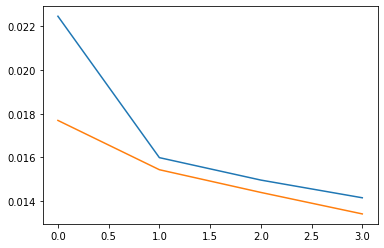

Current learning rate is: 0.001
===> Epoch[5](1/469): Loss: 0.0164 
===> Epoch[5](2/469): Loss: 0.0107 
===> Epoch[5](3/469): Loss: 0.0134 
===> Epoch[5](4/469): Loss: 0.0171 
===> Epoch[5](5/469): Loss: 0.0136 
===> Epoch[5](6/469): Loss: 0.0082 
===> Epoch[5](7/469): Loss: 0.0107 
===> Epoch[5](8/469): Loss: 0.0088 
===> Epoch[5](9/469): Loss: 0.0160 
===> Epoch[5](10/469): Loss: 0.0126 
===> Epoch[5](11/469): Loss: 0.0124 
===> Epoch[5](12/469): Loss: 0.0095 
===> Epoch[5](13/469): Loss: 0.0195 
===> Epoch[5](14/469): Loss: 0.0130 
===> Epoch[5](15/469): Loss: 0.0180 
===> Epoch[5](16/469): Loss: 0.0129 
===> Epoch[5](17/469): Loss: 0.0101 
===> Epoch[5](18/469): Loss: 0.0102 
===> Epoch[5](19/469): Loss: 0.0131 
===> Epoch[5](20/469): Loss: 0.0149 
===> Epoch[5](21/469): Loss: 0.0107 
===> Epoch[5](22/469): Loss: 0.0158 
===> Epoch[5](23/469): Loss: 0.0144 
===> Epoch[5](24/469): Loss: 0.0096 
===> Epoch[5](25/469): Loss: 0.0084 
===> Epoch[5](26/469): Loss: 0.0113 
===> Epoch[5](2

===> Epoch[5](219/469): Loss: 0.0179 
===> Epoch[5](220/469): Loss: 0.0119 
===> Epoch[5](221/469): Loss: 0.0135 
===> Epoch[5](222/469): Loss: 0.0113 
===> Epoch[5](223/469): Loss: 0.0123 
===> Epoch[5](224/469): Loss: 0.0102 
===> Epoch[5](225/469): Loss: 0.0145 
===> Epoch[5](226/469): Loss: 0.0177 
===> Epoch[5](227/469): Loss: 0.0132 
===> Epoch[5](228/469): Loss: 0.0105 
===> Epoch[5](229/469): Loss: 0.0119 
===> Epoch[5](230/469): Loss: 0.0199 
===> Epoch[5](231/469): Loss: 0.0121 
===> Epoch[5](232/469): Loss: 0.0088 
===> Epoch[5](233/469): Loss: 0.0141 
===> Epoch[5](234/469): Loss: 0.0096 
===> Epoch[5](235/469): Loss: 0.0146 
===> Epoch[5](236/469): Loss: 0.0174 
===> Epoch[5](237/469): Loss: 0.0092 
===> Epoch[5](238/469): Loss: 0.0130 
===> Epoch[5](239/469): Loss: 0.0168 
===> Epoch[5](240/469): Loss: 0.0127 
===> Epoch[5](241/469): Loss: 0.0150 
===> Epoch[5](242/469): Loss: 0.0138 
===> Epoch[5](243/469): Loss: 0.0114 
===> Epoch[5](244/469): Loss: 0.0129 
===> Epoch[5

===> Epoch[5](436/469): Loss: 0.0102 
===> Epoch[5](437/469): Loss: 0.0203 
===> Epoch[5](438/469): Loss: 0.0112 
===> Epoch[5](439/469): Loss: 0.0139 
===> Epoch[5](440/469): Loss: 0.0089 
===> Epoch[5](441/469): Loss: 0.0159 
===> Epoch[5](442/469): Loss: 0.0169 
===> Epoch[5](443/469): Loss: 0.0108 
===> Epoch[5](444/469): Loss: 0.0203 
===> Epoch[5](445/469): Loss: 0.0164 
===> Epoch[5](446/469): Loss: 0.0189 
===> Epoch[5](447/469): Loss: 0.0087 
===> Epoch[5](448/469): Loss: 0.0150 
===> Epoch[5](449/469): Loss: 0.0124 
===> Epoch[5](450/469): Loss: 0.0143 
===> Epoch[5](451/469): Loss: 0.0196 
===> Epoch[5](452/469): Loss: 0.0173 
===> Epoch[5](453/469): Loss: 0.0095 
===> Epoch[5](454/469): Loss: 0.0175 
===> Epoch[5](455/469): Loss: 0.0106 
===> Epoch[5](456/469): Loss: 0.0149 
===> Epoch[5](457/469): Loss: 0.0149 
===> Epoch[5](458/469): Loss: 0.0085 
===> Epoch[5](459/469): Loss: 0.0114 
===> Epoch[5](460/469): Loss: 0.0127 
===> Epoch[5](461/469): Loss: 0.0122 
===> Epoch[5

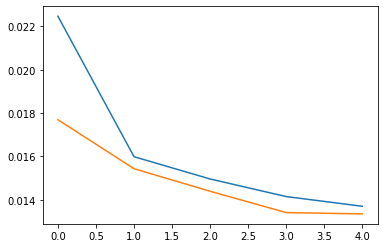

Current learning rate is: 0.001
===> Epoch[6](1/469): Loss: 0.0141 
===> Epoch[6](2/469): Loss: 0.0199 
===> Epoch[6](3/469): Loss: 0.0091 
===> Epoch[6](4/469): Loss: 0.0108 
===> Epoch[6](5/469): Loss: 0.0099 
===> Epoch[6](6/469): Loss: 0.0158 
===> Epoch[6](7/469): Loss: 0.0110 
===> Epoch[6](8/469): Loss: 0.0049 
===> Epoch[6](9/469): Loss: 0.0090 
===> Epoch[6](10/469): Loss: 0.0130 
===> Epoch[6](11/469): Loss: 0.0151 
===> Epoch[6](12/469): Loss: 0.0121 
===> Epoch[6](13/469): Loss: 0.0159 
===> Epoch[6](14/469): Loss: 0.0106 
===> Epoch[6](15/469): Loss: 0.0123 
===> Epoch[6](16/469): Loss: 0.0139 
===> Epoch[6](17/469): Loss: 0.0140 
===> Epoch[6](18/469): Loss: 0.0111 
===> Epoch[6](19/469): Loss: 0.0157 
===> Epoch[6](20/469): Loss: 0.0115 
===> Epoch[6](21/469): Loss: 0.0179 
===> Epoch[6](22/469): Loss: 0.0107 
===> Epoch[6](23/469): Loss: 0.0105 
===> Epoch[6](24/469): Loss: 0.0122 
===> Epoch[6](25/469): Loss: 0.0099 
===> Epoch[6](26/469): Loss: 0.0161 
===> Epoch[6](2

===> Epoch[6](219/469): Loss: 0.0167 
===> Epoch[6](220/469): Loss: 0.0114 
===> Epoch[6](221/469): Loss: 0.0115 
===> Epoch[6](222/469): Loss: 0.0122 
===> Epoch[6](223/469): Loss: 0.0162 
===> Epoch[6](224/469): Loss: 0.0094 
===> Epoch[6](225/469): Loss: 0.0164 
===> Epoch[6](226/469): Loss: 0.0150 
===> Epoch[6](227/469): Loss: 0.0139 
===> Epoch[6](228/469): Loss: 0.0087 
===> Epoch[6](229/469): Loss: 0.0126 
===> Epoch[6](230/469): Loss: 0.0145 
===> Epoch[6](231/469): Loss: 0.0153 
===> Epoch[6](232/469): Loss: 0.0101 
===> Epoch[6](233/469): Loss: 0.0092 
===> Epoch[6](234/469): Loss: 0.0153 
===> Epoch[6](235/469): Loss: 0.0140 
===> Epoch[6](236/469): Loss: 0.0099 
===> Epoch[6](237/469): Loss: 0.0203 
===> Epoch[6](238/469): Loss: 0.0166 
===> Epoch[6](239/469): Loss: 0.0195 
===> Epoch[6](240/469): Loss: 0.0127 
===> Epoch[6](241/469): Loss: 0.0118 
===> Epoch[6](242/469): Loss: 0.0148 
===> Epoch[6](243/469): Loss: 0.0122 
===> Epoch[6](244/469): Loss: 0.0109 
===> Epoch[6

===> Epoch[6](435/469): Loss: 0.0167 
===> Epoch[6](436/469): Loss: 0.0154 
===> Epoch[6](437/469): Loss: 0.0131 
===> Epoch[6](438/469): Loss: 0.0143 
===> Epoch[6](439/469): Loss: 0.0143 
===> Epoch[6](440/469): Loss: 0.0189 
===> Epoch[6](441/469): Loss: 0.0202 
===> Epoch[6](442/469): Loss: 0.0096 
===> Epoch[6](443/469): Loss: 0.0160 
===> Epoch[6](444/469): Loss: 0.0130 
===> Epoch[6](445/469): Loss: 0.0175 
===> Epoch[6](446/469): Loss: 0.0114 
===> Epoch[6](447/469): Loss: 0.0078 
===> Epoch[6](448/469): Loss: 0.0137 
===> Epoch[6](449/469): Loss: 0.0121 
===> Epoch[6](450/469): Loss: 0.0174 
===> Epoch[6](451/469): Loss: 0.0085 
===> Epoch[6](452/469): Loss: 0.0212 
===> Epoch[6](453/469): Loss: 0.0109 
===> Epoch[6](454/469): Loss: 0.0146 
===> Epoch[6](455/469): Loss: 0.0104 
===> Epoch[6](456/469): Loss: 0.0118 
===> Epoch[6](457/469): Loss: 0.0139 
===> Epoch[6](458/469): Loss: 0.0107 
===> Epoch[6](459/469): Loss: 0.0156 
===> Epoch[6](460/469): Loss: 0.0141 
===> Epoch[6

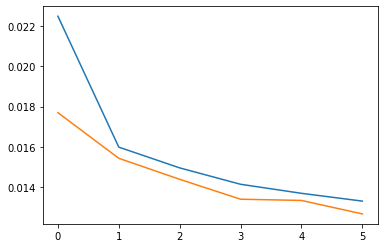

Current learning rate is: 0.001
===> Epoch[7](1/469): Loss: 0.0091 
===> Epoch[7](2/469): Loss: 0.0150 
===> Epoch[7](3/469): Loss: 0.0121 
===> Epoch[7](4/469): Loss: 0.0191 
===> Epoch[7](5/469): Loss: 0.0122 
===> Epoch[7](6/469): Loss: 0.0151 
===> Epoch[7](7/469): Loss: 0.0149 
===> Epoch[7](8/469): Loss: 0.0151 
===> Epoch[7](9/469): Loss: 0.0126 
===> Epoch[7](10/469): Loss: 0.0146 
===> Epoch[7](11/469): Loss: 0.0101 
===> Epoch[7](12/469): Loss: 0.0156 
===> Epoch[7](13/469): Loss: 0.0081 
===> Epoch[7](14/469): Loss: 0.0107 
===> Epoch[7](15/469): Loss: 0.0100 
===> Epoch[7](16/469): Loss: 0.0187 
===> Epoch[7](17/469): Loss: 0.0101 
===> Epoch[7](18/469): Loss: 0.0143 
===> Epoch[7](19/469): Loss: 0.0121 
===> Epoch[7](20/469): Loss: 0.0081 
===> Epoch[7](21/469): Loss: 0.0075 
===> Epoch[7](22/469): Loss: 0.0192 
===> Epoch[7](23/469): Loss: 0.0115 
===> Epoch[7](24/469): Loss: 0.0130 
===> Epoch[7](25/469): Loss: 0.0130 
===> Epoch[7](26/469): Loss: 0.0081 
===> Epoch[7](2

===> Epoch[7](220/469): Loss: 0.0091 
===> Epoch[7](221/469): Loss: 0.0161 
===> Epoch[7](222/469): Loss: 0.0103 
===> Epoch[7](223/469): Loss: 0.0157 
===> Epoch[7](224/469): Loss: 0.0146 
===> Epoch[7](225/469): Loss: 0.0133 
===> Epoch[7](226/469): Loss: 0.0097 
===> Epoch[7](227/469): Loss: 0.0094 
===> Epoch[7](228/469): Loss: 0.0101 
===> Epoch[7](229/469): Loss: 0.0114 
===> Epoch[7](230/469): Loss: 0.0092 
===> Epoch[7](231/469): Loss: 0.0124 
===> Epoch[7](232/469): Loss: 0.0109 
===> Epoch[7](233/469): Loss: 0.0160 
===> Epoch[7](234/469): Loss: 0.0162 
===> Epoch[7](235/469): Loss: 0.0160 
===> Epoch[7](236/469): Loss: 0.0114 
===> Epoch[7](237/469): Loss: 0.0104 
===> Epoch[7](238/469): Loss: 0.0138 
===> Epoch[7](239/469): Loss: 0.0199 
===> Epoch[7](240/469): Loss: 0.0168 
===> Epoch[7](241/469): Loss: 0.0178 
===> Epoch[7](242/469): Loss: 0.0115 
===> Epoch[7](243/469): Loss: 0.0171 
===> Epoch[7](244/469): Loss: 0.0144 
===> Epoch[7](245/469): Loss: 0.0101 
===> Epoch[7

===> Epoch[7](436/469): Loss: 0.0085 
===> Epoch[7](437/469): Loss: 0.0117 
===> Epoch[7](438/469): Loss: 0.0091 
===> Epoch[7](439/469): Loss: 0.0128 
===> Epoch[7](440/469): Loss: 0.0132 
===> Epoch[7](441/469): Loss: 0.0122 
===> Epoch[7](442/469): Loss: 0.0124 
===> Epoch[7](443/469): Loss: 0.0156 
===> Epoch[7](444/469): Loss: 0.0110 
===> Epoch[7](445/469): Loss: 0.0121 
===> Epoch[7](446/469): Loss: 0.0182 
===> Epoch[7](447/469): Loss: 0.0130 
===> Epoch[7](448/469): Loss: 0.0116 
===> Epoch[7](449/469): Loss: 0.0106 
===> Epoch[7](450/469): Loss: 0.0166 
===> Epoch[7](451/469): Loss: 0.0110 
===> Epoch[7](452/469): Loss: 0.0139 
===> Epoch[7](453/469): Loss: 0.0194 
===> Epoch[7](454/469): Loss: 0.0133 
===> Epoch[7](455/469): Loss: 0.0175 
===> Epoch[7](456/469): Loss: 0.0131 
===> Epoch[7](457/469): Loss: 0.0153 
===> Epoch[7](458/469): Loss: 0.0136 
===> Epoch[7](459/469): Loss: 0.0135 
===> Epoch[7](460/469): Loss: 0.0134 
===> Epoch[7](461/469): Loss: 0.0140 
===> Epoch[7

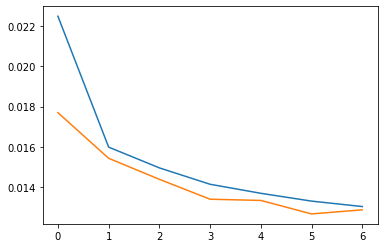

Current learning rate is: 0.001
===> Epoch[8](1/469): Loss: 0.0088 
===> Epoch[8](2/469): Loss: 0.0135 
===> Epoch[8](3/469): Loss: 0.0164 
===> Epoch[8](4/469): Loss: 0.0084 
===> Epoch[8](5/469): Loss: 0.0068 
===> Epoch[8](6/469): Loss: 0.0130 
===> Epoch[8](7/469): Loss: 0.0085 
===> Epoch[8](8/469): Loss: 0.0131 
===> Epoch[8](9/469): Loss: 0.0180 
===> Epoch[8](10/469): Loss: 0.0160 
===> Epoch[8](11/469): Loss: 0.0171 
===> Epoch[8](12/469): Loss: 0.0128 
===> Epoch[8](13/469): Loss: 0.0096 
===> Epoch[8](14/469): Loss: 0.0128 
===> Epoch[8](15/469): Loss: 0.0088 
===> Epoch[8](16/469): Loss: 0.0100 
===> Epoch[8](17/469): Loss: 0.0129 
===> Epoch[8](18/469): Loss: 0.0085 
===> Epoch[8](19/469): Loss: 0.0235 
===> Epoch[8](20/469): Loss: 0.0152 
===> Epoch[8](21/469): Loss: 0.0093 
===> Epoch[8](22/469): Loss: 0.0101 
===> Epoch[8](23/469): Loss: 0.0078 
===> Epoch[8](24/469): Loss: 0.0104 
===> Epoch[8](25/469): Loss: 0.0181 
===> Epoch[8](26/469): Loss: 0.0100 
===> Epoch[8](2

===> Epoch[8](219/469): Loss: 0.0130 
===> Epoch[8](220/469): Loss: 0.0136 
===> Epoch[8](221/469): Loss: 0.0093 
===> Epoch[8](222/469): Loss: 0.0102 
===> Epoch[8](223/469): Loss: 0.0149 
===> Epoch[8](224/469): Loss: 0.0155 
===> Epoch[8](225/469): Loss: 0.0151 
===> Epoch[8](226/469): Loss: 0.0157 
===> Epoch[8](227/469): Loss: 0.0108 
===> Epoch[8](228/469): Loss: 0.0133 
===> Epoch[8](229/469): Loss: 0.0089 
===> Epoch[8](230/469): Loss: 0.0116 
===> Epoch[8](231/469): Loss: 0.0136 
===> Epoch[8](232/469): Loss: 0.0126 
===> Epoch[8](233/469): Loss: 0.0098 
===> Epoch[8](234/469): Loss: 0.0108 
===> Epoch[8](235/469): Loss: 0.0184 
===> Epoch[8](236/469): Loss: 0.0175 
===> Epoch[8](237/469): Loss: 0.0182 
===> Epoch[8](238/469): Loss: 0.0096 
===> Epoch[8](239/469): Loss: 0.0124 
===> Epoch[8](240/469): Loss: 0.0178 
===> Epoch[8](241/469): Loss: 0.0184 
===> Epoch[8](242/469): Loss: 0.0145 
===> Epoch[8](243/469): Loss: 0.0163 
===> Epoch[8](244/469): Loss: 0.0112 
===> Epoch[8

===> Epoch[8](437/469): Loss: 0.0161 
===> Epoch[8](438/469): Loss: 0.0105 
===> Epoch[8](439/469): Loss: 0.0150 
===> Epoch[8](440/469): Loss: 0.0182 
===> Epoch[8](441/469): Loss: 0.0069 
===> Epoch[8](442/469): Loss: 0.0088 
===> Epoch[8](443/469): Loss: 0.0136 
===> Epoch[8](444/469): Loss: 0.0099 
===> Epoch[8](445/469): Loss: 0.0127 
===> Epoch[8](446/469): Loss: 0.0170 
===> Epoch[8](447/469): Loss: 0.0101 
===> Epoch[8](448/469): Loss: 0.0098 
===> Epoch[8](449/469): Loss: 0.0119 
===> Epoch[8](450/469): Loss: 0.0117 
===> Epoch[8](451/469): Loss: 0.0157 
===> Epoch[8](452/469): Loss: 0.0111 
===> Epoch[8](453/469): Loss: 0.0180 
===> Epoch[8](454/469): Loss: 0.0109 
===> Epoch[8](455/469): Loss: 0.0130 
===> Epoch[8](456/469): Loss: 0.0071 
===> Epoch[8](457/469): Loss: 0.0076 
===> Epoch[8](458/469): Loss: 0.0115 
===> Epoch[8](459/469): Loss: 0.0095 
===> Epoch[8](460/469): Loss: 0.0084 
===> Epoch[8](461/469): Loss: 0.0166 
===> Epoch[8](462/469): Loss: 0.0106 
===> Epoch[8

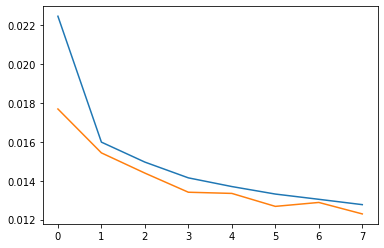

Current learning rate is: 0.001
===> Epoch[9](1/469): Loss: 0.0074 
===> Epoch[9](2/469): Loss: 0.0060 
===> Epoch[9](3/469): Loss: 0.0109 
===> Epoch[9](4/469): Loss: 0.0110 
===> Epoch[9](5/469): Loss: 0.0128 
===> Epoch[9](6/469): Loss: 0.0063 
===> Epoch[9](7/469): Loss: 0.0157 
===> Epoch[9](8/469): Loss: 0.0146 
===> Epoch[9](9/469): Loss: 0.0162 
===> Epoch[9](10/469): Loss: 0.0118 
===> Epoch[9](11/469): Loss: 0.0117 
===> Epoch[9](12/469): Loss: 0.0159 
===> Epoch[9](13/469): Loss: 0.0104 
===> Epoch[9](14/469): Loss: 0.0089 
===> Epoch[9](15/469): Loss: 0.0165 
===> Epoch[9](16/469): Loss: 0.0194 
===> Epoch[9](17/469): Loss: 0.0166 
===> Epoch[9](18/469): Loss: 0.0110 
===> Epoch[9](19/469): Loss: 0.0151 
===> Epoch[9](20/469): Loss: 0.0132 
===> Epoch[9](21/469): Loss: 0.0172 
===> Epoch[9](22/469): Loss: 0.0155 
===> Epoch[9](23/469): Loss: 0.0170 
===> Epoch[9](24/469): Loss: 0.0139 
===> Epoch[9](25/469): Loss: 0.0169 
===> Epoch[9](26/469): Loss: 0.0192 
===> Epoch[9](2

===> Epoch[9](220/469): Loss: 0.0109 
===> Epoch[9](221/469): Loss: 0.0095 
===> Epoch[9](222/469): Loss: 0.0159 
===> Epoch[9](223/469): Loss: 0.0107 
===> Epoch[9](224/469): Loss: 0.0142 
===> Epoch[9](225/469): Loss: 0.0112 
===> Epoch[9](226/469): Loss: 0.0103 
===> Epoch[9](227/469): Loss: 0.0202 
===> Epoch[9](228/469): Loss: 0.0135 
===> Epoch[9](229/469): Loss: 0.0165 
===> Epoch[9](230/469): Loss: 0.0116 
===> Epoch[9](231/469): Loss: 0.0105 
===> Epoch[9](232/469): Loss: 0.0236 
===> Epoch[9](233/469): Loss: 0.0100 
===> Epoch[9](234/469): Loss: 0.0104 
===> Epoch[9](235/469): Loss: 0.0127 
===> Epoch[9](236/469): Loss: 0.0115 
===> Epoch[9](237/469): Loss: 0.0134 
===> Epoch[9](238/469): Loss: 0.0097 
===> Epoch[9](239/469): Loss: 0.0095 
===> Epoch[9](240/469): Loss: 0.0137 
===> Epoch[9](241/469): Loss: 0.0155 
===> Epoch[9](242/469): Loss: 0.0161 
===> Epoch[9](243/469): Loss: 0.0083 
===> Epoch[9](244/469): Loss: 0.0098 
===> Epoch[9](245/469): Loss: 0.0115 
===> Epoch[9

===> Epoch[9](439/469): Loss: 0.0123 
===> Epoch[9](440/469): Loss: 0.0085 
===> Epoch[9](441/469): Loss: 0.0161 
===> Epoch[9](442/469): Loss: 0.0136 
===> Epoch[9](443/469): Loss: 0.0159 
===> Epoch[9](444/469): Loss: 0.0125 
===> Epoch[9](445/469): Loss: 0.0102 
===> Epoch[9](446/469): Loss: 0.0167 
===> Epoch[9](447/469): Loss: 0.0127 
===> Epoch[9](448/469): Loss: 0.0076 
===> Epoch[9](449/469): Loss: 0.0108 
===> Epoch[9](450/469): Loss: 0.0111 
===> Epoch[9](451/469): Loss: 0.0150 
===> Epoch[9](452/469): Loss: 0.0162 
===> Epoch[9](453/469): Loss: 0.0165 
===> Epoch[9](454/469): Loss: 0.0113 
===> Epoch[9](455/469): Loss: 0.0108 
===> Epoch[9](456/469): Loss: 0.0116 
===> Epoch[9](457/469): Loss: 0.0156 
===> Epoch[9](458/469): Loss: 0.0208 
===> Epoch[9](459/469): Loss: 0.0114 
===> Epoch[9](460/469): Loss: 0.0159 
===> Epoch[9](461/469): Loss: 0.0115 
===> Epoch[9](462/469): Loss: 0.0116 
===> Epoch[9](463/469): Loss: 0.0098 
===> Epoch[9](464/469): Loss: 0.0122 
===> Epoch[9

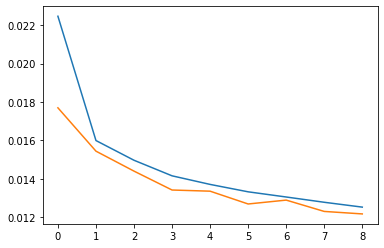

Current learning rate is: 0.001
===> Epoch[10](1/469): Loss: 0.0151 
===> Epoch[10](2/469): Loss: 0.0108 
===> Epoch[10](3/469): Loss: 0.0115 
===> Epoch[10](4/469): Loss: 0.0128 
===> Epoch[10](5/469): Loss: 0.0206 
===> Epoch[10](6/469): Loss: 0.0113 
===> Epoch[10](7/469): Loss: 0.0169 
===> Epoch[10](8/469): Loss: 0.0110 
===> Epoch[10](9/469): Loss: 0.0164 
===> Epoch[10](10/469): Loss: 0.0134 
===> Epoch[10](11/469): Loss: 0.0177 
===> Epoch[10](12/469): Loss: 0.0110 
===> Epoch[10](13/469): Loss: 0.0086 
===> Epoch[10](14/469): Loss: 0.0125 
===> Epoch[10](15/469): Loss: 0.0092 
===> Epoch[10](16/469): Loss: 0.0089 
===> Epoch[10](17/469): Loss: 0.0097 
===> Epoch[10](18/469): Loss: 0.0130 
===> Epoch[10](19/469): Loss: 0.0115 
===> Epoch[10](20/469): Loss: 0.0094 
===> Epoch[10](21/469): Loss: 0.0088 
===> Epoch[10](22/469): Loss: 0.0169 
===> Epoch[10](23/469): Loss: 0.0091 
===> Epoch[10](24/469): Loss: 0.0132 
===> Epoch[10](25/469): Loss: 0.0168 
===> Epoch[10](26/469): Los

===> Epoch[10](216/469): Loss: 0.0152 
===> Epoch[10](217/469): Loss: 0.0151 
===> Epoch[10](218/469): Loss: 0.0123 
===> Epoch[10](219/469): Loss: 0.0143 
===> Epoch[10](220/469): Loss: 0.0182 
===> Epoch[10](221/469): Loss: 0.0112 
===> Epoch[10](222/469): Loss: 0.0086 
===> Epoch[10](223/469): Loss: 0.0138 
===> Epoch[10](224/469): Loss: 0.0085 
===> Epoch[10](225/469): Loss: 0.0117 
===> Epoch[10](226/469): Loss: 0.0096 
===> Epoch[10](227/469): Loss: 0.0076 
===> Epoch[10](228/469): Loss: 0.0079 
===> Epoch[10](229/469): Loss: 0.0089 
===> Epoch[10](230/469): Loss: 0.0121 
===> Epoch[10](231/469): Loss: 0.0129 
===> Epoch[10](232/469): Loss: 0.0140 
===> Epoch[10](233/469): Loss: 0.0119 
===> Epoch[10](234/469): Loss: 0.0110 
===> Epoch[10](235/469): Loss: 0.0142 
===> Epoch[10](236/469): Loss: 0.0079 
===> Epoch[10](237/469): Loss: 0.0104 
===> Epoch[10](238/469): Loss: 0.0085 
===> Epoch[10](239/469): Loss: 0.0129 
===> Epoch[10](240/469): Loss: 0.0128 
===> Epoch[10](241/469): 

===> Epoch[10](430/469): Loss: 0.0067 
===> Epoch[10](431/469): Loss: 0.0136 
===> Epoch[10](432/469): Loss: 0.0107 
===> Epoch[10](433/469): Loss: 0.0129 
===> Epoch[10](434/469): Loss: 0.0113 
===> Epoch[10](435/469): Loss: 0.0077 
===> Epoch[10](436/469): Loss: 0.0097 
===> Epoch[10](437/469): Loss: 0.0102 
===> Epoch[10](438/469): Loss: 0.0093 
===> Epoch[10](439/469): Loss: 0.0140 
===> Epoch[10](440/469): Loss: 0.0142 
===> Epoch[10](441/469): Loss: 0.0120 
===> Epoch[10](442/469): Loss: 0.0117 
===> Epoch[10](443/469): Loss: 0.0133 
===> Epoch[10](444/469): Loss: 0.0177 
===> Epoch[10](445/469): Loss: 0.0094 
===> Epoch[10](446/469): Loss: 0.0180 
===> Epoch[10](447/469): Loss: 0.0163 
===> Epoch[10](448/469): Loss: 0.0170 
===> Epoch[10](449/469): Loss: 0.0103 
===> Epoch[10](450/469): Loss: 0.0099 
===> Epoch[10](451/469): Loss: 0.0174 
===> Epoch[10](452/469): Loss: 0.0227 
===> Epoch[10](453/469): Loss: 0.0111 
===> Epoch[10](454/469): Loss: 0.0163 
===> Epoch[10](455/469): 

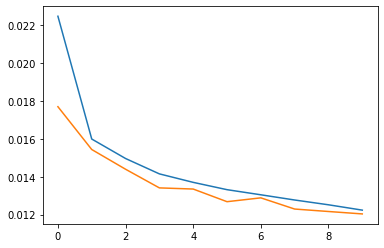

Current learning rate is: 0.001
===> Epoch[11](1/469): Loss: 0.0068 
===> Epoch[11](2/469): Loss: 0.0095 
===> Epoch[11](3/469): Loss: 0.0170 
===> Epoch[11](4/469): Loss: 0.0114 
===> Epoch[11](5/469): Loss: 0.0106 
===> Epoch[11](6/469): Loss: 0.0117 
===> Epoch[11](7/469): Loss: 0.0185 
===> Epoch[11](8/469): Loss: 0.0129 
===> Epoch[11](9/469): Loss: 0.0070 
===> Epoch[11](10/469): Loss: 0.0194 
===> Epoch[11](11/469): Loss: 0.0107 
===> Epoch[11](12/469): Loss: 0.0194 
===> Epoch[11](13/469): Loss: 0.0092 
===> Epoch[11](14/469): Loss: 0.0085 
===> Epoch[11](15/469): Loss: 0.0230 
===> Epoch[11](16/469): Loss: 0.0097 
===> Epoch[11](17/469): Loss: 0.0074 
===> Epoch[11](18/469): Loss: 0.0109 
===> Epoch[11](19/469): Loss: 0.0161 
===> Epoch[11](20/469): Loss: 0.0077 
===> Epoch[11](21/469): Loss: 0.0063 
===> Epoch[11](22/469): Loss: 0.0124 
===> Epoch[11](23/469): Loss: 0.0121 
===> Epoch[11](24/469): Loss: 0.0069 
===> Epoch[11](25/469): Loss: 0.0131 
===> Epoch[11](26/469): Los

===> Epoch[11](216/469): Loss: 0.0151 
===> Epoch[11](217/469): Loss: 0.0154 
===> Epoch[11](218/469): Loss: 0.0096 
===> Epoch[11](219/469): Loss: 0.0128 
===> Epoch[11](220/469): Loss: 0.0113 
===> Epoch[11](221/469): Loss: 0.0125 
===> Epoch[11](222/469): Loss: 0.0105 
===> Epoch[11](223/469): Loss: 0.0171 
===> Epoch[11](224/469): Loss: 0.0146 
===> Epoch[11](225/469): Loss: 0.0179 
===> Epoch[11](226/469): Loss: 0.0069 
===> Epoch[11](227/469): Loss: 0.0172 
===> Epoch[11](228/469): Loss: 0.0109 
===> Epoch[11](229/469): Loss: 0.0128 
===> Epoch[11](230/469): Loss: 0.0120 
===> Epoch[11](231/469): Loss: 0.0109 
===> Epoch[11](232/469): Loss: 0.0102 
===> Epoch[11](233/469): Loss: 0.0132 
===> Epoch[11](234/469): Loss: 0.0125 
===> Epoch[11](235/469): Loss: 0.0122 
===> Epoch[11](236/469): Loss: 0.0170 
===> Epoch[11](237/469): Loss: 0.0156 
===> Epoch[11](238/469): Loss: 0.0131 
===> Epoch[11](239/469): Loss: 0.0130 
===> Epoch[11](240/469): Loss: 0.0131 
===> Epoch[11](241/469): 

===> Epoch[11](430/469): Loss: 0.0125 
===> Epoch[11](431/469): Loss: 0.0112 
===> Epoch[11](432/469): Loss: 0.0169 
===> Epoch[11](433/469): Loss: 0.0161 
===> Epoch[11](434/469): Loss: 0.0091 
===> Epoch[11](435/469): Loss: 0.0108 
===> Epoch[11](436/469): Loss: 0.0119 
===> Epoch[11](437/469): Loss: 0.0087 
===> Epoch[11](438/469): Loss: 0.0109 
===> Epoch[11](439/469): Loss: 0.0075 
===> Epoch[11](440/469): Loss: 0.0167 
===> Epoch[11](441/469): Loss: 0.0188 
===> Epoch[11](442/469): Loss: 0.0089 
===> Epoch[11](443/469): Loss: 0.0122 
===> Epoch[11](444/469): Loss: 0.0151 
===> Epoch[11](445/469): Loss: 0.0092 
===> Epoch[11](446/469): Loss: 0.0157 
===> Epoch[11](447/469): Loss: 0.0175 
===> Epoch[11](448/469): Loss: 0.0137 
===> Epoch[11](449/469): Loss: 0.0122 
===> Epoch[11](450/469): Loss: 0.0061 
===> Epoch[11](451/469): Loss: 0.0144 
===> Epoch[11](452/469): Loss: 0.0105 
===> Epoch[11](453/469): Loss: 0.0138 
===> Epoch[11](454/469): Loss: 0.0136 
===> Epoch[11](455/469): 

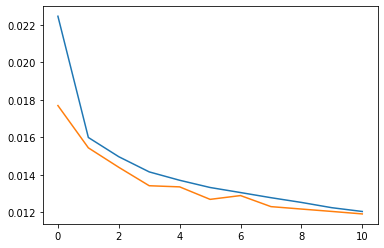

Current learning rate is: 0.001
===> Epoch[12](1/469): Loss: 0.0111 
===> Epoch[12](2/469): Loss: 0.0082 
===> Epoch[12](3/469): Loss: 0.0065 
===> Epoch[12](4/469): Loss: 0.0108 
===> Epoch[12](5/469): Loss: 0.0098 
===> Epoch[12](6/469): Loss: 0.0098 
===> Epoch[12](7/469): Loss: 0.0177 
===> Epoch[12](8/469): Loss: 0.0065 
===> Epoch[12](9/469): Loss: 0.0130 
===> Epoch[12](10/469): Loss: 0.0113 
===> Epoch[12](11/469): Loss: 0.0146 
===> Epoch[12](12/469): Loss: 0.0071 
===> Epoch[12](13/469): Loss: 0.0117 
===> Epoch[12](14/469): Loss: 0.0103 
===> Epoch[12](15/469): Loss: 0.0124 
===> Epoch[12](16/469): Loss: 0.0084 
===> Epoch[12](17/469): Loss: 0.0118 
===> Epoch[12](18/469): Loss: 0.0112 
===> Epoch[12](19/469): Loss: 0.0117 
===> Epoch[12](20/469): Loss: 0.0111 
===> Epoch[12](21/469): Loss: 0.0154 
===> Epoch[12](22/469): Loss: 0.0190 
===> Epoch[12](23/469): Loss: 0.0134 
===> Epoch[12](24/469): Loss: 0.0093 
===> Epoch[12](25/469): Loss: 0.0135 
===> Epoch[12](26/469): Los

===> Epoch[12](215/469): Loss: 0.0090 
===> Epoch[12](216/469): Loss: 0.0113 
===> Epoch[12](217/469): Loss: 0.0068 
===> Epoch[12](218/469): Loss: 0.0173 
===> Epoch[12](219/469): Loss: 0.0098 
===> Epoch[12](220/469): Loss: 0.0128 
===> Epoch[12](221/469): Loss: 0.0145 
===> Epoch[12](222/469): Loss: 0.0079 
===> Epoch[12](223/469): Loss: 0.0155 
===> Epoch[12](224/469): Loss: 0.0138 
===> Epoch[12](225/469): Loss: 0.0176 
===> Epoch[12](226/469): Loss: 0.0129 
===> Epoch[12](227/469): Loss: 0.0118 
===> Epoch[12](228/469): Loss: 0.0103 
===> Epoch[12](229/469): Loss: 0.0068 
===> Epoch[12](230/469): Loss: 0.0148 
===> Epoch[12](231/469): Loss: 0.0049 
===> Epoch[12](232/469): Loss: 0.0147 
===> Epoch[12](233/469): Loss: 0.0106 
===> Epoch[12](234/469): Loss: 0.0091 
===> Epoch[12](235/469): Loss: 0.0178 
===> Epoch[12](236/469): Loss: 0.0083 
===> Epoch[12](237/469): Loss: 0.0114 
===> Epoch[12](238/469): Loss: 0.0153 
===> Epoch[12](239/469): Loss: 0.0059 
===> Epoch[12](240/469): 

===> Epoch[12](426/469): Loss: 0.0153 
===> Epoch[12](427/469): Loss: 0.0106 
===> Epoch[12](428/469): Loss: 0.0118 
===> Epoch[12](429/469): Loss: 0.0136 
===> Epoch[12](430/469): Loss: 0.0153 
===> Epoch[12](431/469): Loss: 0.0155 
===> Epoch[12](432/469): Loss: 0.0150 
===> Epoch[12](433/469): Loss: 0.0097 
===> Epoch[12](434/469): Loss: 0.0185 
===> Epoch[12](435/469): Loss: 0.0126 
===> Epoch[12](436/469): Loss: 0.0103 
===> Epoch[12](437/469): Loss: 0.0120 
===> Epoch[12](438/469): Loss: 0.0084 
===> Epoch[12](439/469): Loss: 0.0115 
===> Epoch[12](440/469): Loss: 0.0072 
===> Epoch[12](441/469): Loss: 0.0102 
===> Epoch[12](442/469): Loss: 0.0107 
===> Epoch[12](443/469): Loss: 0.0122 
===> Epoch[12](444/469): Loss: 0.0165 
===> Epoch[12](445/469): Loss: 0.0149 
===> Epoch[12](446/469): Loss: 0.0161 
===> Epoch[12](447/469): Loss: 0.0102 
===> Epoch[12](448/469): Loss: 0.0089 
===> Epoch[12](449/469): Loss: 0.0153 
===> Epoch[12](450/469): Loss: 0.0090 
===> Epoch[12](451/469): 

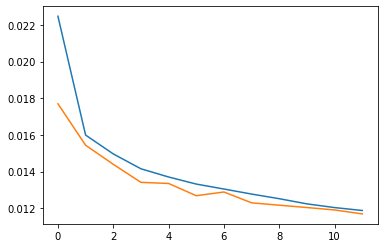

Current learning rate is: 0.001
===> Epoch[13](1/469): Loss: 0.0085 
===> Epoch[13](2/469): Loss: 0.0057 
===> Epoch[13](3/469): Loss: 0.0081 
===> Epoch[13](4/469): Loss: 0.0085 
===> Epoch[13](5/469): Loss: 0.0073 
===> Epoch[13](6/469): Loss: 0.0085 
===> Epoch[13](7/469): Loss: 0.0084 
===> Epoch[13](8/469): Loss: 0.0078 
===> Epoch[13](9/469): Loss: 0.0066 
===> Epoch[13](10/469): Loss: 0.0175 
===> Epoch[13](11/469): Loss: 0.0207 
===> Epoch[13](12/469): Loss: 0.0154 
===> Epoch[13](13/469): Loss: 0.0086 
===> Epoch[13](14/469): Loss: 0.0141 
===> Epoch[13](15/469): Loss: 0.0119 
===> Epoch[13](16/469): Loss: 0.0123 
===> Epoch[13](17/469): Loss: 0.0154 
===> Epoch[13](18/469): Loss: 0.0106 
===> Epoch[13](19/469): Loss: 0.0094 
===> Epoch[13](20/469): Loss: 0.0113 
===> Epoch[13](21/469): Loss: 0.0118 
===> Epoch[13](22/469): Loss: 0.0076 
===> Epoch[13](23/469): Loss: 0.0133 
===> Epoch[13](24/469): Loss: 0.0083 
===> Epoch[13](25/469): Loss: 0.0123 
===> Epoch[13](26/469): Los

===> Epoch[13](215/469): Loss: 0.0114 
===> Epoch[13](216/469): Loss: 0.0122 
===> Epoch[13](217/469): Loss: 0.0163 
===> Epoch[13](218/469): Loss: 0.0084 
===> Epoch[13](219/469): Loss: 0.0157 
===> Epoch[13](220/469): Loss: 0.0058 
===> Epoch[13](221/469): Loss: 0.0175 
===> Epoch[13](222/469): Loss: 0.0118 
===> Epoch[13](223/469): Loss: 0.0093 
===> Epoch[13](224/469): Loss: 0.0176 
===> Epoch[13](225/469): Loss: 0.0179 
===> Epoch[13](226/469): Loss: 0.0065 
===> Epoch[13](227/469): Loss: 0.0144 
===> Epoch[13](228/469): Loss: 0.0143 
===> Epoch[13](229/469): Loss: 0.0120 
===> Epoch[13](230/469): Loss: 0.0132 
===> Epoch[13](231/469): Loss: 0.0173 
===> Epoch[13](232/469): Loss: 0.0081 
===> Epoch[13](233/469): Loss: 0.0092 
===> Epoch[13](234/469): Loss: 0.0105 
===> Epoch[13](235/469): Loss: 0.0098 
===> Epoch[13](236/469): Loss: 0.0113 
===> Epoch[13](237/469): Loss: 0.0086 
===> Epoch[13](238/469): Loss: 0.0142 
===> Epoch[13](239/469): Loss: 0.0113 
===> Epoch[13](240/469): 

===> Epoch[13](427/469): Loss: 0.0094 
===> Epoch[13](428/469): Loss: 0.0162 
===> Epoch[13](429/469): Loss: 0.0104 
===> Epoch[13](430/469): Loss: 0.0086 
===> Epoch[13](431/469): Loss: 0.0089 
===> Epoch[13](432/469): Loss: 0.0126 
===> Epoch[13](433/469): Loss: 0.0151 
===> Epoch[13](434/469): Loss: 0.0161 
===> Epoch[13](435/469): Loss: 0.0120 
===> Epoch[13](436/469): Loss: 0.0108 
===> Epoch[13](437/469): Loss: 0.0124 
===> Epoch[13](438/469): Loss: 0.0106 
===> Epoch[13](439/469): Loss: 0.0105 
===> Epoch[13](440/469): Loss: 0.0113 
===> Epoch[13](441/469): Loss: 0.0138 
===> Epoch[13](442/469): Loss: 0.0136 
===> Epoch[13](443/469): Loss: 0.0134 
===> Epoch[13](444/469): Loss: 0.0080 
===> Epoch[13](445/469): Loss: 0.0067 
===> Epoch[13](446/469): Loss: 0.0070 
===> Epoch[13](447/469): Loss: 0.0087 
===> Epoch[13](448/469): Loss: 0.0119 
===> Epoch[13](449/469): Loss: 0.0117 
===> Epoch[13](450/469): Loss: 0.0115 
===> Epoch[13](451/469): Loss: 0.0048 
===> Epoch[13](452/469): 

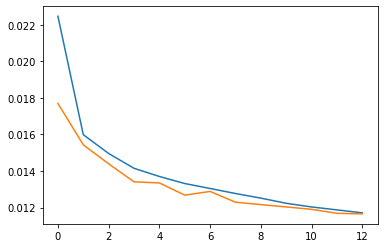

Current learning rate is: 0.001
===> Epoch[14](1/469): Loss: 0.0133 
===> Epoch[14](2/469): Loss: 0.0179 
===> Epoch[14](3/469): Loss: 0.0127 
===> Epoch[14](4/469): Loss: 0.0169 
===> Epoch[14](5/469): Loss: 0.0077 
===> Epoch[14](6/469): Loss: 0.0112 
===> Epoch[14](7/469): Loss: 0.0143 
===> Epoch[14](8/469): Loss: 0.0074 
===> Epoch[14](9/469): Loss: 0.0123 
===> Epoch[14](10/469): Loss: 0.0132 
===> Epoch[14](11/469): Loss: 0.0105 
===> Epoch[14](12/469): Loss: 0.0112 
===> Epoch[14](13/469): Loss: 0.0137 
===> Epoch[14](14/469): Loss: 0.0105 
===> Epoch[14](15/469): Loss: 0.0050 
===> Epoch[14](16/469): Loss: 0.0108 
===> Epoch[14](17/469): Loss: 0.0131 
===> Epoch[14](18/469): Loss: 0.0141 
===> Epoch[14](19/469): Loss: 0.0112 
===> Epoch[14](20/469): Loss: 0.0101 
===> Epoch[14](21/469): Loss: 0.0122 
===> Epoch[14](22/469): Loss: 0.0132 
===> Epoch[14](23/469): Loss: 0.0130 
===> Epoch[14](24/469): Loss: 0.0107 
===> Epoch[14](25/469): Loss: 0.0184 
===> Epoch[14](26/469): Los

===> Epoch[14](217/469): Loss: 0.0075 
===> Epoch[14](218/469): Loss: 0.0125 
===> Epoch[14](219/469): Loss: 0.0211 
===> Epoch[14](220/469): Loss: 0.0117 
===> Epoch[14](221/469): Loss: 0.0095 
===> Epoch[14](222/469): Loss: 0.0108 
===> Epoch[14](223/469): Loss: 0.0098 
===> Epoch[14](224/469): Loss: 0.0158 
===> Epoch[14](225/469): Loss: 0.0100 
===> Epoch[14](226/469): Loss: 0.0105 
===> Epoch[14](227/469): Loss: 0.0177 
===> Epoch[14](228/469): Loss: 0.0079 
===> Epoch[14](229/469): Loss: 0.0089 
===> Epoch[14](230/469): Loss: 0.0116 
===> Epoch[14](231/469): Loss: 0.0119 
===> Epoch[14](232/469): Loss: 0.0124 
===> Epoch[14](233/469): Loss: 0.0130 
===> Epoch[14](234/469): Loss: 0.0091 
===> Epoch[14](235/469): Loss: 0.0065 
===> Epoch[14](236/469): Loss: 0.0108 
===> Epoch[14](237/469): Loss: 0.0166 
===> Epoch[14](238/469): Loss: 0.0165 
===> Epoch[14](239/469): Loss: 0.0108 
===> Epoch[14](240/469): Loss: 0.0114 
===> Epoch[14](241/469): Loss: 0.0101 
===> Epoch[14](242/469): 

===> Epoch[14](428/469): Loss: 0.0101 
===> Epoch[14](429/469): Loss: 0.0140 
===> Epoch[14](430/469): Loss: 0.0145 
===> Epoch[14](431/469): Loss: 0.0121 
===> Epoch[14](432/469): Loss: 0.0150 
===> Epoch[14](433/469): Loss: 0.0109 
===> Epoch[14](434/469): Loss: 0.0088 
===> Epoch[14](435/469): Loss: 0.0102 
===> Epoch[14](436/469): Loss: 0.0154 
===> Epoch[14](437/469): Loss: 0.0107 
===> Epoch[14](438/469): Loss: 0.0155 
===> Epoch[14](439/469): Loss: 0.0115 
===> Epoch[14](440/469): Loss: 0.0098 
===> Epoch[14](441/469): Loss: 0.0123 
===> Epoch[14](442/469): Loss: 0.0116 
===> Epoch[14](443/469): Loss: 0.0095 
===> Epoch[14](444/469): Loss: 0.0114 
===> Epoch[14](445/469): Loss: 0.0131 
===> Epoch[14](446/469): Loss: 0.0156 
===> Epoch[14](447/469): Loss: 0.0099 
===> Epoch[14](448/469): Loss: 0.0114 
===> Epoch[14](449/469): Loss: 0.0109 
===> Epoch[14](450/469): Loss: 0.0159 
===> Epoch[14](451/469): Loss: 0.0123 
===> Epoch[14](452/469): Loss: 0.0073 
===> Epoch[14](453/469): 

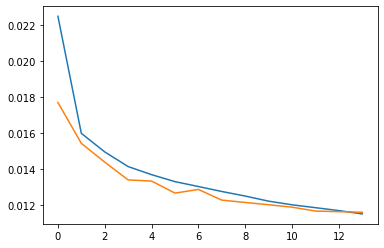

Current learning rate is: 0.001
===> Epoch[15](1/469): Loss: 0.0148 
===> Epoch[15](2/469): Loss: 0.0070 
===> Epoch[15](3/469): Loss: 0.0134 
===> Epoch[15](4/469): Loss: 0.0107 
===> Epoch[15](5/469): Loss: 0.0087 
===> Epoch[15](6/469): Loss: 0.0124 
===> Epoch[15](7/469): Loss: 0.0114 
===> Epoch[15](8/469): Loss: 0.0118 
===> Epoch[15](9/469): Loss: 0.0110 
===> Epoch[15](10/469): Loss: 0.0092 
===> Epoch[15](11/469): Loss: 0.0087 
===> Epoch[15](12/469): Loss: 0.0101 
===> Epoch[15](13/469): Loss: 0.0130 
===> Epoch[15](14/469): Loss: 0.0164 
===> Epoch[15](15/469): Loss: 0.0131 
===> Epoch[15](16/469): Loss: 0.0163 
===> Epoch[15](17/469): Loss: 0.0225 
===> Epoch[15](18/469): Loss: 0.0174 
===> Epoch[15](19/469): Loss: 0.0123 
===> Epoch[15](20/469): Loss: 0.0094 
===> Epoch[15](21/469): Loss: 0.0109 
===> Epoch[15](22/469): Loss: 0.0076 
===> Epoch[15](23/469): Loss: 0.0137 
===> Epoch[15](24/469): Loss: 0.0104 
===> Epoch[15](25/469): Loss: 0.0087 
===> Epoch[15](26/469): Los

===> Epoch[15](216/469): Loss: 0.0100 
===> Epoch[15](217/469): Loss: 0.0123 
===> Epoch[15](218/469): Loss: 0.0127 
===> Epoch[15](219/469): Loss: 0.0079 
===> Epoch[15](220/469): Loss: 0.0101 
===> Epoch[15](221/469): Loss: 0.0104 
===> Epoch[15](222/469): Loss: 0.0141 
===> Epoch[15](223/469): Loss: 0.0106 
===> Epoch[15](224/469): Loss: 0.0148 
===> Epoch[15](225/469): Loss: 0.0109 
===> Epoch[15](226/469): Loss: 0.0117 
===> Epoch[15](227/469): Loss: 0.0078 
===> Epoch[15](228/469): Loss: 0.0090 
===> Epoch[15](229/469): Loss: 0.0098 
===> Epoch[15](230/469): Loss: 0.0116 
===> Epoch[15](231/469): Loss: 0.0124 
===> Epoch[15](232/469): Loss: 0.0117 
===> Epoch[15](233/469): Loss: 0.0145 
===> Epoch[15](234/469): Loss: 0.0122 
===> Epoch[15](235/469): Loss: 0.0156 
===> Epoch[15](236/469): Loss: 0.0134 
===> Epoch[15](237/469): Loss: 0.0088 
===> Epoch[15](238/469): Loss: 0.0139 
===> Epoch[15](239/469): Loss: 0.0116 
===> Epoch[15](240/469): Loss: 0.0147 
===> Epoch[15](241/469): 

===> Epoch[15](428/469): Loss: 0.0076 
===> Epoch[15](429/469): Loss: 0.0125 
===> Epoch[15](430/469): Loss: 0.0071 
===> Epoch[15](431/469): Loss: 0.0102 
===> Epoch[15](432/469): Loss: 0.0069 
===> Epoch[15](433/469): Loss: 0.0133 
===> Epoch[15](434/469): Loss: 0.0087 
===> Epoch[15](435/469): Loss: 0.0157 
===> Epoch[15](436/469): Loss: 0.0119 
===> Epoch[15](437/469): Loss: 0.0139 
===> Epoch[15](438/469): Loss: 0.0079 
===> Epoch[15](439/469): Loss: 0.0128 
===> Epoch[15](440/469): Loss: 0.0113 
===> Epoch[15](441/469): Loss: 0.0110 
===> Epoch[15](442/469): Loss: 0.0156 
===> Epoch[15](443/469): Loss: 0.0054 
===> Epoch[15](444/469): Loss: 0.0073 
===> Epoch[15](445/469): Loss: 0.0106 
===> Epoch[15](446/469): Loss: 0.0100 
===> Epoch[15](447/469): Loss: 0.0083 
===> Epoch[15](448/469): Loss: 0.0095 
===> Epoch[15](449/469): Loss: 0.0078 
===> Epoch[15](450/469): Loss: 0.0137 
===> Epoch[15](451/469): Loss: 0.0094 
===> Epoch[15](452/469): Loss: 0.0126 
===> Epoch[15](453/469): 

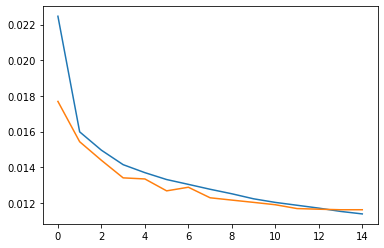

Current learning rate is: 0.001
===> Epoch[16](1/469): Loss: 0.0098 
===> Epoch[16](2/469): Loss: 0.0073 
===> Epoch[16](3/469): Loss: 0.0111 
===> Epoch[16](4/469): Loss: 0.0045 
===> Epoch[16](5/469): Loss: 0.0097 
===> Epoch[16](6/469): Loss: 0.0144 
===> Epoch[16](7/469): Loss: 0.0103 
===> Epoch[16](8/469): Loss: 0.0118 
===> Epoch[16](9/469): Loss: 0.0107 
===> Epoch[16](10/469): Loss: 0.0098 
===> Epoch[16](11/469): Loss: 0.0084 
===> Epoch[16](12/469): Loss: 0.0062 
===> Epoch[16](13/469): Loss: 0.0173 
===> Epoch[16](14/469): Loss: 0.0114 
===> Epoch[16](15/469): Loss: 0.0128 
===> Epoch[16](16/469): Loss: 0.0097 
===> Epoch[16](17/469): Loss: 0.0106 
===> Epoch[16](18/469): Loss: 0.0116 
===> Epoch[16](19/469): Loss: 0.0088 
===> Epoch[16](20/469): Loss: 0.0145 
===> Epoch[16](21/469): Loss: 0.0147 
===> Epoch[16](22/469): Loss: 0.0208 
===> Epoch[16](23/469): Loss: 0.0195 
===> Epoch[16](24/469): Loss: 0.0103 
===> Epoch[16](25/469): Loss: 0.0110 
===> Epoch[16](26/469): Los

===> Epoch[16](214/469): Loss: 0.0100 
===> Epoch[16](215/469): Loss: 0.0115 
===> Epoch[16](216/469): Loss: 0.0068 
===> Epoch[16](217/469): Loss: 0.0070 
===> Epoch[16](218/469): Loss: 0.0116 
===> Epoch[16](219/469): Loss: 0.0111 
===> Epoch[16](220/469): Loss: 0.0120 
===> Epoch[16](221/469): Loss: 0.0147 
===> Epoch[16](222/469): Loss: 0.0118 
===> Epoch[16](223/469): Loss: 0.0103 
===> Epoch[16](224/469): Loss: 0.0104 
===> Epoch[16](225/469): Loss: 0.0079 
===> Epoch[16](226/469): Loss: 0.0144 
===> Epoch[16](227/469): Loss: 0.0048 
===> Epoch[16](228/469): Loss: 0.0140 
===> Epoch[16](229/469): Loss: 0.0125 
===> Epoch[16](230/469): Loss: 0.0145 
===> Epoch[16](231/469): Loss: 0.0087 
===> Epoch[16](232/469): Loss: 0.0121 
===> Epoch[16](233/469): Loss: 0.0100 
===> Epoch[16](234/469): Loss: 0.0087 
===> Epoch[16](235/469): Loss: 0.0116 
===> Epoch[16](236/469): Loss: 0.0131 
===> Epoch[16](237/469): Loss: 0.0131 
===> Epoch[16](238/469): Loss: 0.0134 
===> Epoch[16](239/469): 

===> Epoch[16](426/469): Loss: 0.0112 
===> Epoch[16](427/469): Loss: 0.0096 
===> Epoch[16](428/469): Loss: 0.0111 
===> Epoch[16](429/469): Loss: 0.0110 
===> Epoch[16](430/469): Loss: 0.0074 
===> Epoch[16](431/469): Loss: 0.0135 
===> Epoch[16](432/469): Loss: 0.0077 
===> Epoch[16](433/469): Loss: 0.0155 
===> Epoch[16](434/469): Loss: 0.0076 
===> Epoch[16](435/469): Loss: 0.0096 
===> Epoch[16](436/469): Loss: 0.0140 
===> Epoch[16](437/469): Loss: 0.0100 
===> Epoch[16](438/469): Loss: 0.0104 
===> Epoch[16](439/469): Loss: 0.0126 
===> Epoch[16](440/469): Loss: 0.0122 
===> Epoch[16](441/469): Loss: 0.0108 
===> Epoch[16](442/469): Loss: 0.0146 
===> Epoch[16](443/469): Loss: 0.0113 
===> Epoch[16](444/469): Loss: 0.0064 
===> Epoch[16](445/469): Loss: 0.0123 
===> Epoch[16](446/469): Loss: 0.0133 
===> Epoch[16](447/469): Loss: 0.0090 
===> Epoch[16](448/469): Loss: 0.0085 
===> Epoch[16](449/469): Loss: 0.0074 
===> Epoch[16](450/469): Loss: 0.0123 
===> Epoch[16](451/469): 

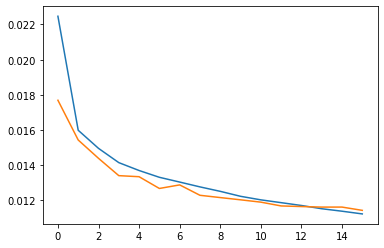

Current learning rate is: 0.001
===> Epoch[17](1/469): Loss: 0.0128 
===> Epoch[17](2/469): Loss: 0.0064 
===> Epoch[17](3/469): Loss: 0.0155 
===> Epoch[17](4/469): Loss: 0.0119 
===> Epoch[17](5/469): Loss: 0.0121 
===> Epoch[17](6/469): Loss: 0.0085 
===> Epoch[17](7/469): Loss: 0.0151 
===> Epoch[17](8/469): Loss: 0.0090 
===> Epoch[17](9/469): Loss: 0.0098 
===> Epoch[17](10/469): Loss: 0.0100 
===> Epoch[17](11/469): Loss: 0.0097 
===> Epoch[17](12/469): Loss: 0.0066 
===> Epoch[17](13/469): Loss: 0.0084 
===> Epoch[17](14/469): Loss: 0.0158 
===> Epoch[17](15/469): Loss: 0.0075 
===> Epoch[17](16/469): Loss: 0.0098 
===> Epoch[17](17/469): Loss: 0.0123 
===> Epoch[17](18/469): Loss: 0.0156 
===> Epoch[17](19/469): Loss: 0.0090 
===> Epoch[17](20/469): Loss: 0.0106 
===> Epoch[17](21/469): Loss: 0.0083 
===> Epoch[17](22/469): Loss: 0.0083 
===> Epoch[17](23/469): Loss: 0.0077 
===> Epoch[17](24/469): Loss: 0.0091 
===> Epoch[17](25/469): Loss: 0.0115 
===> Epoch[17](26/469): Los

===> Epoch[17](216/469): Loss: 0.0078 
===> Epoch[17](217/469): Loss: 0.0103 
===> Epoch[17](218/469): Loss: 0.0059 
===> Epoch[17](219/469): Loss: 0.0101 
===> Epoch[17](220/469): Loss: 0.0099 
===> Epoch[17](221/469): Loss: 0.0077 
===> Epoch[17](222/469): Loss: 0.0113 
===> Epoch[17](223/469): Loss: 0.0094 
===> Epoch[17](224/469): Loss: 0.0049 
===> Epoch[17](225/469): Loss: 0.0124 
===> Epoch[17](226/469): Loss: 0.0113 
===> Epoch[17](227/469): Loss: 0.0116 
===> Epoch[17](228/469): Loss: 0.0160 
===> Epoch[17](229/469): Loss: 0.0061 
===> Epoch[17](230/469): Loss: 0.0135 
===> Epoch[17](231/469): Loss: 0.0055 
===> Epoch[17](232/469): Loss: 0.0136 
===> Epoch[17](233/469): Loss: 0.0129 
===> Epoch[17](234/469): Loss: 0.0114 
===> Epoch[17](235/469): Loss: 0.0108 
===> Epoch[17](236/469): Loss: 0.0074 
===> Epoch[17](237/469): Loss: 0.0144 
===> Epoch[17](238/469): Loss: 0.0116 
===> Epoch[17](239/469): Loss: 0.0058 
===> Epoch[17](240/469): Loss: 0.0080 
===> Epoch[17](241/469): 

===> Epoch[17](428/469): Loss: 0.0116 
===> Epoch[17](429/469): Loss: 0.0151 
===> Epoch[17](430/469): Loss: 0.0125 
===> Epoch[17](431/469): Loss: 0.0140 
===> Epoch[17](432/469): Loss: 0.0097 
===> Epoch[17](433/469): Loss: 0.0084 
===> Epoch[17](434/469): Loss: 0.0114 
===> Epoch[17](435/469): Loss: 0.0155 
===> Epoch[17](436/469): Loss: 0.0107 
===> Epoch[17](437/469): Loss: 0.0130 
===> Epoch[17](438/469): Loss: 0.0093 
===> Epoch[17](439/469): Loss: 0.0091 
===> Epoch[17](440/469): Loss: 0.0165 
===> Epoch[17](441/469): Loss: 0.0108 
===> Epoch[17](442/469): Loss: 0.0067 
===> Epoch[17](443/469): Loss: 0.0093 
===> Epoch[17](444/469): Loss: 0.0117 
===> Epoch[17](445/469): Loss: 0.0102 
===> Epoch[17](446/469): Loss: 0.0152 
===> Epoch[17](447/469): Loss: 0.0138 
===> Epoch[17](448/469): Loss: 0.0065 
===> Epoch[17](449/469): Loss: 0.0112 
===> Epoch[17](450/469): Loss: 0.0061 
===> Epoch[17](451/469): Loss: 0.0097 
===> Epoch[17](452/469): Loss: 0.0105 
===> Epoch[17](453/469): 

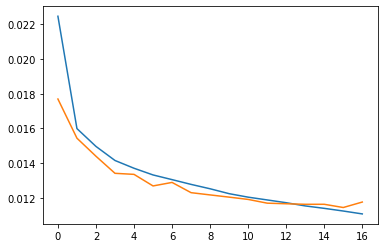

Current learning rate is: 0.001
===> Epoch[18](1/469): Loss: 0.0111 
===> Epoch[18](2/469): Loss: 0.0105 
===> Epoch[18](3/469): Loss: 0.0154 
===> Epoch[18](4/469): Loss: 0.0116 
===> Epoch[18](5/469): Loss: 0.0064 
===> Epoch[18](6/469): Loss: 0.0058 
===> Epoch[18](7/469): Loss: 0.0092 
===> Epoch[18](8/469): Loss: 0.0091 
===> Epoch[18](9/469): Loss: 0.0140 
===> Epoch[18](10/469): Loss: 0.0061 
===> Epoch[18](11/469): Loss: 0.0171 
===> Epoch[18](12/469): Loss: 0.0111 
===> Epoch[18](13/469): Loss: 0.0046 
===> Epoch[18](14/469): Loss: 0.0085 
===> Epoch[18](15/469): Loss: 0.0085 
===> Epoch[18](16/469): Loss: 0.0130 
===> Epoch[18](17/469): Loss: 0.0089 
===> Epoch[18](18/469): Loss: 0.0138 
===> Epoch[18](19/469): Loss: 0.0127 
===> Epoch[18](20/469): Loss: 0.0134 
===> Epoch[18](21/469): Loss: 0.0115 
===> Epoch[18](22/469): Loss: 0.0080 
===> Epoch[18](23/469): Loss: 0.0108 
===> Epoch[18](24/469): Loss: 0.0134 
===> Epoch[18](25/469): Loss: 0.0080 
===> Epoch[18](26/469): Los

===> Epoch[18](215/469): Loss: 0.0179 
===> Epoch[18](216/469): Loss: 0.0103 
===> Epoch[18](217/469): Loss: 0.0071 
===> Epoch[18](218/469): Loss: 0.0113 
===> Epoch[18](219/469): Loss: 0.0149 
===> Epoch[18](220/469): Loss: 0.0095 
===> Epoch[18](221/469): Loss: 0.0171 
===> Epoch[18](222/469): Loss: 0.0103 
===> Epoch[18](223/469): Loss: 0.0119 
===> Epoch[18](224/469): Loss: 0.0162 
===> Epoch[18](225/469): Loss: 0.0128 
===> Epoch[18](226/469): Loss: 0.0121 
===> Epoch[18](227/469): Loss: 0.0068 
===> Epoch[18](228/469): Loss: 0.0118 
===> Epoch[18](229/469): Loss: 0.0075 
===> Epoch[18](230/469): Loss: 0.0119 
===> Epoch[18](231/469): Loss: 0.0109 
===> Epoch[18](232/469): Loss: 0.0121 
===> Epoch[18](233/469): Loss: 0.0094 
===> Epoch[18](234/469): Loss: 0.0124 
===> Epoch[18](235/469): Loss: 0.0120 
===> Epoch[18](236/469): Loss: 0.0138 
===> Epoch[18](237/469): Loss: 0.0111 
===> Epoch[18](238/469): Loss: 0.0094 
===> Epoch[18](239/469): Loss: 0.0066 
===> Epoch[18](240/469): 

===> Epoch[18](429/469): Loss: 0.0131 
===> Epoch[18](430/469): Loss: 0.0109 
===> Epoch[18](431/469): Loss: 0.0099 
===> Epoch[18](432/469): Loss: 0.0104 
===> Epoch[18](433/469): Loss: 0.0141 
===> Epoch[18](434/469): Loss: 0.0114 
===> Epoch[18](435/469): Loss: 0.0081 
===> Epoch[18](436/469): Loss: 0.0113 
===> Epoch[18](437/469): Loss: 0.0095 
===> Epoch[18](438/469): Loss: 0.0177 
===> Epoch[18](439/469): Loss: 0.0122 
===> Epoch[18](440/469): Loss: 0.0096 
===> Epoch[18](441/469): Loss: 0.0104 
===> Epoch[18](442/469): Loss: 0.0120 
===> Epoch[18](443/469): Loss: 0.0092 
===> Epoch[18](444/469): Loss: 0.0108 
===> Epoch[18](445/469): Loss: 0.0107 
===> Epoch[18](446/469): Loss: 0.0111 
===> Epoch[18](447/469): Loss: 0.0097 
===> Epoch[18](448/469): Loss: 0.0120 
===> Epoch[18](449/469): Loss: 0.0076 
===> Epoch[18](450/469): Loss: 0.0122 
===> Epoch[18](451/469): Loss: 0.0128 
===> Epoch[18](452/469): Loss: 0.0071 
===> Epoch[18](453/469): Loss: 0.0123 
===> Epoch[18](454/469): 

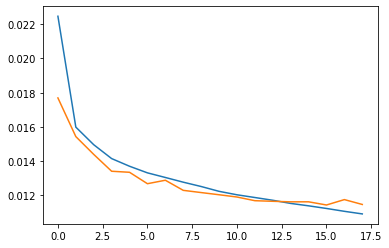

Current learning rate is: 0.001
===> Epoch[19](1/469): Loss: 0.0130 
===> Epoch[19](2/469): Loss: 0.0112 
===> Epoch[19](3/469): Loss: 0.0157 
===> Epoch[19](4/469): Loss: 0.0081 
===> Epoch[19](5/469): Loss: 0.0071 
===> Epoch[19](6/469): Loss: 0.0064 
===> Epoch[19](7/469): Loss: 0.0078 
===> Epoch[19](8/469): Loss: 0.0066 
===> Epoch[19](9/469): Loss: 0.0058 
===> Epoch[19](10/469): Loss: 0.0090 
===> Epoch[19](11/469): Loss: 0.0066 
===> Epoch[19](12/469): Loss: 0.0100 
===> Epoch[19](13/469): Loss: 0.0105 
===> Epoch[19](14/469): Loss: 0.0123 
===> Epoch[19](15/469): Loss: 0.0085 
===> Epoch[19](16/469): Loss: 0.0084 
===> Epoch[19](17/469): Loss: 0.0088 
===> Epoch[19](18/469): Loss: 0.0094 
===> Epoch[19](19/469): Loss: 0.0111 
===> Epoch[19](20/469): Loss: 0.0118 
===> Epoch[19](21/469): Loss: 0.0105 
===> Epoch[19](22/469): Loss: 0.0095 
===> Epoch[19](23/469): Loss: 0.0095 
===> Epoch[19](24/469): Loss: 0.0118 
===> Epoch[19](25/469): Loss: 0.0090 
===> Epoch[19](26/469): Los

===> Epoch[19](216/469): Loss: 0.0072 
===> Epoch[19](217/469): Loss: 0.0057 
===> Epoch[19](218/469): Loss: 0.0089 
===> Epoch[19](219/469): Loss: 0.0091 
===> Epoch[19](220/469): Loss: 0.0125 
===> Epoch[19](221/469): Loss: 0.0121 
===> Epoch[19](222/469): Loss: 0.0111 
===> Epoch[19](223/469): Loss: 0.0096 
===> Epoch[19](224/469): Loss: 0.0136 
===> Epoch[19](225/469): Loss: 0.0069 
===> Epoch[19](226/469): Loss: 0.0108 
===> Epoch[19](227/469): Loss: 0.0122 
===> Epoch[19](228/469): Loss: 0.0108 
===> Epoch[19](229/469): Loss: 0.0073 
===> Epoch[19](230/469): Loss: 0.0106 
===> Epoch[19](231/469): Loss: 0.0107 
===> Epoch[19](232/469): Loss: 0.0083 
===> Epoch[19](233/469): Loss: 0.0091 
===> Epoch[19](234/469): Loss: 0.0094 
===> Epoch[19](235/469): Loss: 0.0125 
===> Epoch[19](236/469): Loss: 0.0062 
===> Epoch[19](237/469): Loss: 0.0123 
===> Epoch[19](238/469): Loss: 0.0121 
===> Epoch[19](239/469): Loss: 0.0087 
===> Epoch[19](240/469): Loss: 0.0125 
===> Epoch[19](241/469): 

===> Epoch[19](428/469): Loss: 0.0078 
===> Epoch[19](429/469): Loss: 0.0081 
===> Epoch[19](430/469): Loss: 0.0090 
===> Epoch[19](431/469): Loss: 0.0125 
===> Epoch[19](432/469): Loss: 0.0101 
===> Epoch[19](433/469): Loss: 0.0131 
===> Epoch[19](434/469): Loss: 0.0146 
===> Epoch[19](435/469): Loss: 0.0130 
===> Epoch[19](436/469): Loss: 0.0099 
===> Epoch[19](437/469): Loss: 0.0117 
===> Epoch[19](438/469): Loss: 0.0085 
===> Epoch[19](439/469): Loss: 0.0053 
===> Epoch[19](440/469): Loss: 0.0082 
===> Epoch[19](441/469): Loss: 0.0156 
===> Epoch[19](442/469): Loss: 0.0162 
===> Epoch[19](443/469): Loss: 0.0122 
===> Epoch[19](444/469): Loss: 0.0081 
===> Epoch[19](445/469): Loss: 0.0103 
===> Epoch[19](446/469): Loss: 0.0110 
===> Epoch[19](447/469): Loss: 0.0082 
===> Epoch[19](448/469): Loss: 0.0103 
===> Epoch[19](449/469): Loss: 0.0061 
===> Epoch[19](450/469): Loss: 0.0077 
===> Epoch[19](451/469): Loss: 0.0099 
===> Epoch[19](452/469): Loss: 0.0075 
===> Epoch[19](453/469): 

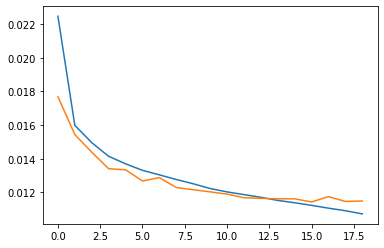

Current learning rate is: 0.001
===> Epoch[20](1/469): Loss: 0.0098 
===> Epoch[20](2/469): Loss: 0.0148 
===> Epoch[20](3/469): Loss: 0.0134 
===> Epoch[20](4/469): Loss: 0.0101 
===> Epoch[20](5/469): Loss: 0.0111 
===> Epoch[20](6/469): Loss: 0.0084 
===> Epoch[20](7/469): Loss: 0.0115 
===> Epoch[20](8/469): Loss: 0.0085 
===> Epoch[20](9/469): Loss: 0.0072 
===> Epoch[20](10/469): Loss: 0.0100 
===> Epoch[20](11/469): Loss: 0.0096 
===> Epoch[20](12/469): Loss: 0.0085 
===> Epoch[20](13/469): Loss: 0.0069 
===> Epoch[20](14/469): Loss: 0.0110 
===> Epoch[20](15/469): Loss: 0.0101 
===> Epoch[20](16/469): Loss: 0.0110 
===> Epoch[20](17/469): Loss: 0.0076 
===> Epoch[20](18/469): Loss: 0.0135 
===> Epoch[20](19/469): Loss: 0.0105 
===> Epoch[20](20/469): Loss: 0.0120 
===> Epoch[20](21/469): Loss: 0.0075 
===> Epoch[20](22/469): Loss: 0.0085 
===> Epoch[20](23/469): Loss: 0.0141 
===> Epoch[20](24/469): Loss: 0.0104 
===> Epoch[20](25/469): Loss: 0.0079 
===> Epoch[20](26/469): Los

===> Epoch[20](214/469): Loss: 0.0098 
===> Epoch[20](215/469): Loss: 0.0065 
===> Epoch[20](216/469): Loss: 0.0100 
===> Epoch[20](217/469): Loss: 0.0152 
===> Epoch[20](218/469): Loss: 0.0106 
===> Epoch[20](219/469): Loss: 0.0107 
===> Epoch[20](220/469): Loss: 0.0091 
===> Epoch[20](221/469): Loss: 0.0134 
===> Epoch[20](222/469): Loss: 0.0108 
===> Epoch[20](223/469): Loss: 0.0086 
===> Epoch[20](224/469): Loss: 0.0071 
===> Epoch[20](225/469): Loss: 0.0155 
===> Epoch[20](226/469): Loss: 0.0151 
===> Epoch[20](227/469): Loss: 0.0105 
===> Epoch[20](228/469): Loss: 0.0132 
===> Epoch[20](229/469): Loss: 0.0083 
===> Epoch[20](230/469): Loss: 0.0135 
===> Epoch[20](231/469): Loss: 0.0090 
===> Epoch[20](232/469): Loss: 0.0134 
===> Epoch[20](233/469): Loss: 0.0180 
===> Epoch[20](234/469): Loss: 0.0089 
===> Epoch[20](235/469): Loss: 0.0089 
===> Epoch[20](236/469): Loss: 0.0101 
===> Epoch[20](237/469): Loss: 0.0114 
===> Epoch[20](238/469): Loss: 0.0060 
===> Epoch[20](239/469): 

===> Epoch[20](427/469): Loss: 0.0101 
===> Epoch[20](428/469): Loss: 0.0105 
===> Epoch[20](429/469): Loss: 0.0103 
===> Epoch[20](430/469): Loss: 0.0130 
===> Epoch[20](431/469): Loss: 0.0053 
===> Epoch[20](432/469): Loss: 0.0090 
===> Epoch[20](433/469): Loss: 0.0107 
===> Epoch[20](434/469): Loss: 0.0136 
===> Epoch[20](435/469): Loss: 0.0077 
===> Epoch[20](436/469): Loss: 0.0120 
===> Epoch[20](437/469): Loss: 0.0074 
===> Epoch[20](438/469): Loss: 0.0097 
===> Epoch[20](439/469): Loss: 0.0093 
===> Epoch[20](440/469): Loss: 0.0101 
===> Epoch[20](441/469): Loss: 0.0090 
===> Epoch[20](442/469): Loss: 0.0081 
===> Epoch[20](443/469): Loss: 0.0102 
===> Epoch[20](444/469): Loss: 0.0052 
===> Epoch[20](445/469): Loss: 0.0119 
===> Epoch[20](446/469): Loss: 0.0087 
===> Epoch[20](447/469): Loss: 0.0090 
===> Epoch[20](448/469): Loss: 0.0116 
===> Epoch[20](449/469): Loss: 0.0064 
===> Epoch[20](450/469): Loss: 0.0105 
===> Epoch[20](451/469): Loss: 0.0059 
===> Epoch[20](452/469): 

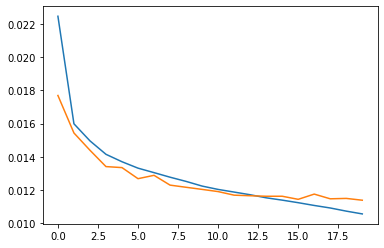

Current learning rate is: 0.001
===> Epoch[21](1/469): Loss: 0.0144 
===> Epoch[21](2/469): Loss: 0.0084 
===> Epoch[21](3/469): Loss: 0.0079 
===> Epoch[21](4/469): Loss: 0.0083 
===> Epoch[21](5/469): Loss: 0.0093 
===> Epoch[21](6/469): Loss: 0.0106 
===> Epoch[21](7/469): Loss: 0.0078 
===> Epoch[21](8/469): Loss: 0.0102 
===> Epoch[21](9/469): Loss: 0.0132 
===> Epoch[21](10/469): Loss: 0.0115 
===> Epoch[21](11/469): Loss: 0.0093 
===> Epoch[21](12/469): Loss: 0.0114 
===> Epoch[21](13/469): Loss: 0.0110 
===> Epoch[21](14/469): Loss: 0.0118 
===> Epoch[21](15/469): Loss: 0.0070 
===> Epoch[21](16/469): Loss: 0.0065 
===> Epoch[21](17/469): Loss: 0.0104 
===> Epoch[21](18/469): Loss: 0.0062 
===> Epoch[21](19/469): Loss: 0.0073 
===> Epoch[21](20/469): Loss: 0.0058 
===> Epoch[21](21/469): Loss: 0.0085 
===> Epoch[21](22/469): Loss: 0.0126 
===> Epoch[21](23/469): Loss: 0.0153 
===> Epoch[21](24/469): Loss: 0.0091 
===> Epoch[21](25/469): Loss: 0.0059 
===> Epoch[21](26/469): Los

===> Epoch[21](216/469): Loss: 0.0085 
===> Epoch[21](217/469): Loss: 0.0103 
===> Epoch[21](218/469): Loss: 0.0100 
===> Epoch[21](219/469): Loss: 0.0048 
===> Epoch[21](220/469): Loss: 0.0078 
===> Epoch[21](221/469): Loss: 0.0076 
===> Epoch[21](222/469): Loss: 0.0102 
===> Epoch[21](223/469): Loss: 0.0096 
===> Epoch[21](224/469): Loss: 0.0135 
===> Epoch[21](225/469): Loss: 0.0057 
===> Epoch[21](226/469): Loss: 0.0096 
===> Epoch[21](227/469): Loss: 0.0099 
===> Epoch[21](228/469): Loss: 0.0088 
===> Epoch[21](229/469): Loss: 0.0123 
===> Epoch[21](230/469): Loss: 0.0125 
===> Epoch[21](231/469): Loss: 0.0187 
===> Epoch[21](232/469): Loss: 0.0113 
===> Epoch[21](233/469): Loss: 0.0063 
===> Epoch[21](234/469): Loss: 0.0183 
===> Epoch[21](235/469): Loss: 0.0086 
===> Epoch[21](236/469): Loss: 0.0129 
===> Epoch[21](237/469): Loss: 0.0127 
===> Epoch[21](238/469): Loss: 0.0115 
===> Epoch[21](239/469): Loss: 0.0066 
===> Epoch[21](240/469): Loss: 0.0166 
===> Epoch[21](241/469): 

===> Epoch[21](428/469): Loss: 0.0088 
===> Epoch[21](429/469): Loss: 0.0071 
===> Epoch[21](430/469): Loss: 0.0119 
===> Epoch[21](431/469): Loss: 0.0094 
===> Epoch[21](432/469): Loss: 0.0087 
===> Epoch[21](433/469): Loss: 0.0070 
===> Epoch[21](434/469): Loss: 0.0092 
===> Epoch[21](435/469): Loss: 0.0101 
===> Epoch[21](436/469): Loss: 0.0071 
===> Epoch[21](437/469): Loss: 0.0094 
===> Epoch[21](438/469): Loss: 0.0091 
===> Epoch[21](439/469): Loss: 0.0141 
===> Epoch[21](440/469): Loss: 0.0101 
===> Epoch[21](441/469): Loss: 0.0127 
===> Epoch[21](442/469): Loss: 0.0084 
===> Epoch[21](443/469): Loss: 0.0089 
===> Epoch[21](444/469): Loss: 0.0111 
===> Epoch[21](445/469): Loss: 0.0092 
===> Epoch[21](446/469): Loss: 0.0105 
===> Epoch[21](447/469): Loss: 0.0138 
===> Epoch[21](448/469): Loss: 0.0093 
===> Epoch[21](449/469): Loss: 0.0079 
===> Epoch[21](450/469): Loss: 0.0073 
===> Epoch[21](451/469): Loss: 0.0092 
===> Epoch[21](452/469): Loss: 0.0123 
===> Epoch[21](453/469): 

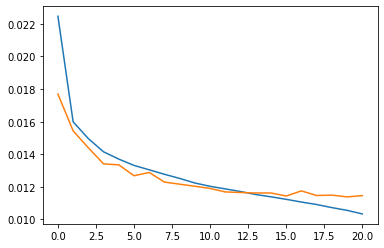

Current learning rate is: 0.001
===> Epoch[22](1/469): Loss: 0.0060 
===> Epoch[22](2/469): Loss: 0.0147 
===> Epoch[22](3/469): Loss: 0.0059 
===> Epoch[22](4/469): Loss: 0.0071 
===> Epoch[22](5/469): Loss: 0.0081 
===> Epoch[22](6/469): Loss: 0.0087 
===> Epoch[22](7/469): Loss: 0.0066 
===> Epoch[22](8/469): Loss: 0.0074 
===> Epoch[22](9/469): Loss: 0.0071 
===> Epoch[22](10/469): Loss: 0.0086 
===> Epoch[22](11/469): Loss: 0.0071 
===> Epoch[22](12/469): Loss: 0.0094 
===> Epoch[22](13/469): Loss: 0.0117 
===> Epoch[22](14/469): Loss: 0.0110 
===> Epoch[22](15/469): Loss: 0.0052 
===> Epoch[22](16/469): Loss: 0.0065 
===> Epoch[22](17/469): Loss: 0.0108 
===> Epoch[22](18/469): Loss: 0.0085 
===> Epoch[22](19/469): Loss: 0.0085 
===> Epoch[22](20/469): Loss: 0.0090 
===> Epoch[22](21/469): Loss: 0.0133 
===> Epoch[22](22/469): Loss: 0.0098 
===> Epoch[22](23/469): Loss: 0.0088 
===> Epoch[22](24/469): Loss: 0.0139 
===> Epoch[22](25/469): Loss: 0.0084 
===> Epoch[22](26/469): Los

===> Epoch[22](216/469): Loss: 0.0085 
===> Epoch[22](217/469): Loss: 0.0137 
===> Epoch[22](218/469): Loss: 0.0092 
===> Epoch[22](219/469): Loss: 0.0103 
===> Epoch[22](220/469): Loss: 0.0122 
===> Epoch[22](221/469): Loss: 0.0125 
===> Epoch[22](222/469): Loss: 0.0079 
===> Epoch[22](223/469): Loss: 0.0075 
===> Epoch[22](224/469): Loss: 0.0075 
===> Epoch[22](225/469): Loss: 0.0093 
===> Epoch[22](226/469): Loss: 0.0128 
===> Epoch[22](227/469): Loss: 0.0072 
===> Epoch[22](228/469): Loss: 0.0106 
===> Epoch[22](229/469): Loss: 0.0098 
===> Epoch[22](230/469): Loss: 0.0090 
===> Epoch[22](231/469): Loss: 0.0072 
===> Epoch[22](232/469): Loss: 0.0089 
===> Epoch[22](233/469): Loss: 0.0182 
===> Epoch[22](234/469): Loss: 0.0085 
===> Epoch[22](235/469): Loss: 0.0097 
===> Epoch[22](236/469): Loss: 0.0113 
===> Epoch[22](237/469): Loss: 0.0107 
===> Epoch[22](238/469): Loss: 0.0119 
===> Epoch[22](239/469): Loss: 0.0098 
===> Epoch[22](240/469): Loss: 0.0132 
===> Epoch[22](241/469): 

===> Epoch[22](430/469): Loss: 0.0040 
===> Epoch[22](431/469): Loss: 0.0121 
===> Epoch[22](432/469): Loss: 0.0111 
===> Epoch[22](433/469): Loss: 0.0148 
===> Epoch[22](434/469): Loss: 0.0102 
===> Epoch[22](435/469): Loss: 0.0059 
===> Epoch[22](436/469): Loss: 0.0071 
===> Epoch[22](437/469): Loss: 0.0058 
===> Epoch[22](438/469): Loss: 0.0145 
===> Epoch[22](439/469): Loss: 0.0100 
===> Epoch[22](440/469): Loss: 0.0059 
===> Epoch[22](441/469): Loss: 0.0102 
===> Epoch[22](442/469): Loss: 0.0112 
===> Epoch[22](443/469): Loss: 0.0089 
===> Epoch[22](444/469): Loss: 0.0088 
===> Epoch[22](445/469): Loss: 0.0071 
===> Epoch[22](446/469): Loss: 0.0129 
===> Epoch[22](447/469): Loss: 0.0123 
===> Epoch[22](448/469): Loss: 0.0140 
===> Epoch[22](449/469): Loss: 0.0132 
===> Epoch[22](450/469): Loss: 0.0085 
===> Epoch[22](451/469): Loss: 0.0073 
===> Epoch[22](452/469): Loss: 0.0076 
===> Epoch[22](453/469): Loss: 0.0057 
===> Epoch[22](454/469): Loss: 0.0204 
===> Epoch[22](455/469): 

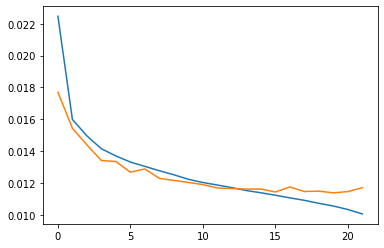

Current learning rate is: 0.001
===> Epoch[23](1/469): Loss: 0.0097 
===> Epoch[23](2/469): Loss: 0.0070 
===> Epoch[23](3/469): Loss: 0.0138 
===> Epoch[23](4/469): Loss: 0.0156 
===> Epoch[23](5/469): Loss: 0.0159 
===> Epoch[23](6/469): Loss: 0.0142 
===> Epoch[23](7/469): Loss: 0.0078 
===> Epoch[23](8/469): Loss: 0.0080 
===> Epoch[23](9/469): Loss: 0.0088 
===> Epoch[23](10/469): Loss: 0.0077 
===> Epoch[23](11/469): Loss: 0.0077 
===> Epoch[23](12/469): Loss: 0.0092 
===> Epoch[23](13/469): Loss: 0.0064 
===> Epoch[23](14/469): Loss: 0.0068 
===> Epoch[23](15/469): Loss: 0.0095 
===> Epoch[23](16/469): Loss: 0.0054 
===> Epoch[23](17/469): Loss: 0.0136 
===> Epoch[23](18/469): Loss: 0.0085 
===> Epoch[23](19/469): Loss: 0.0078 
===> Epoch[23](20/469): Loss: 0.0121 
===> Epoch[23](21/469): Loss: 0.0101 
===> Epoch[23](22/469): Loss: 0.0077 
===> Epoch[23](23/469): Loss: 0.0088 
===> Epoch[23](24/469): Loss: 0.0111 
===> Epoch[23](25/469): Loss: 0.0128 
===> Epoch[23](26/469): Los

===> Epoch[23](214/469): Loss: 0.0075 
===> Epoch[23](215/469): Loss: 0.0074 
===> Epoch[23](216/469): Loss: 0.0081 
===> Epoch[23](217/469): Loss: 0.0128 
===> Epoch[23](218/469): Loss: 0.0071 
===> Epoch[23](219/469): Loss: 0.0077 
===> Epoch[23](220/469): Loss: 0.0101 
===> Epoch[23](221/469): Loss: 0.0104 
===> Epoch[23](222/469): Loss: 0.0109 
===> Epoch[23](223/469): Loss: 0.0093 
===> Epoch[23](224/469): Loss: 0.0121 
===> Epoch[23](225/469): Loss: 0.0058 
===> Epoch[23](226/469): Loss: 0.0083 
===> Epoch[23](227/469): Loss: 0.0074 
===> Epoch[23](228/469): Loss: 0.0112 
===> Epoch[23](229/469): Loss: 0.0075 
===> Epoch[23](230/469): Loss: 0.0068 
===> Epoch[23](231/469): Loss: 0.0067 
===> Epoch[23](232/469): Loss: 0.0131 
===> Epoch[23](233/469): Loss: 0.0090 
===> Epoch[23](234/469): Loss: 0.0095 
===> Epoch[23](235/469): Loss: 0.0090 
===> Epoch[23](236/469): Loss: 0.0071 
===> Epoch[23](237/469): Loss: 0.0117 
===> Epoch[23](238/469): Loss: 0.0105 
===> Epoch[23](239/469): 

===> Epoch[23](427/469): Loss: 0.0071 
===> Epoch[23](428/469): Loss: 0.0110 
===> Epoch[23](429/469): Loss: 0.0096 
===> Epoch[23](430/469): Loss: 0.0121 
===> Epoch[23](431/469): Loss: 0.0113 
===> Epoch[23](432/469): Loss: 0.0138 
===> Epoch[23](433/469): Loss: 0.0139 
===> Epoch[23](434/469): Loss: 0.0099 
===> Epoch[23](435/469): Loss: 0.0188 
===> Epoch[23](436/469): Loss: 0.0104 
===> Epoch[23](437/469): Loss: 0.0097 
===> Epoch[23](438/469): Loss: 0.0120 
===> Epoch[23](439/469): Loss: 0.0101 
===> Epoch[23](440/469): Loss: 0.0047 
===> Epoch[23](441/469): Loss: 0.0108 
===> Epoch[23](442/469): Loss: 0.0110 
===> Epoch[23](443/469): Loss: 0.0111 
===> Epoch[23](444/469): Loss: 0.0083 
===> Epoch[23](445/469): Loss: 0.0069 
===> Epoch[23](446/469): Loss: 0.0062 
===> Epoch[23](447/469): Loss: 0.0147 
===> Epoch[23](448/469): Loss: 0.0137 
===> Epoch[23](449/469): Loss: 0.0108 
===> Epoch[23](450/469): Loss: 0.0156 
===> Epoch[23](451/469): Loss: 0.0040 
===> Epoch[23](452/469): 

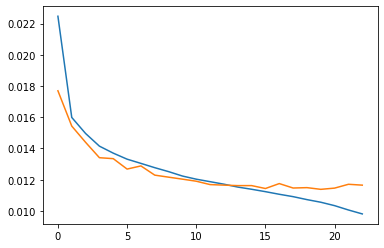

Current learning rate is: 0.001
===> Epoch[24](1/469): Loss: 0.0100 
===> Epoch[24](2/469): Loss: 0.0040 
===> Epoch[24](3/469): Loss: 0.0112 
===> Epoch[24](4/469): Loss: 0.0105 
===> Epoch[24](5/469): Loss: 0.0107 
===> Epoch[24](6/469): Loss: 0.0077 
===> Epoch[24](7/469): Loss: 0.0092 
===> Epoch[24](8/469): Loss: 0.0107 
===> Epoch[24](9/469): Loss: 0.0066 
===> Epoch[24](10/469): Loss: 0.0088 
===> Epoch[24](11/469): Loss: 0.0093 
===> Epoch[24](12/469): Loss: 0.0063 
===> Epoch[24](13/469): Loss: 0.0155 
===> Epoch[24](14/469): Loss: 0.0099 
===> Epoch[24](15/469): Loss: 0.0087 
===> Epoch[24](16/469): Loss: 0.0084 
===> Epoch[24](17/469): Loss: 0.0095 
===> Epoch[24](18/469): Loss: 0.0095 
===> Epoch[24](19/469): Loss: 0.0069 
===> Epoch[24](20/469): Loss: 0.0071 
===> Epoch[24](21/469): Loss: 0.0067 
===> Epoch[24](22/469): Loss: 0.0157 
===> Epoch[24](23/469): Loss: 0.0097 
===> Epoch[24](24/469): Loss: 0.0129 
===> Epoch[24](25/469): Loss: 0.0071 
===> Epoch[24](26/469): Los

===> Epoch[24](214/469): Loss: 0.0104 
===> Epoch[24](215/469): Loss: 0.0095 
===> Epoch[24](216/469): Loss: 0.0063 
===> Epoch[24](217/469): Loss: 0.0142 
===> Epoch[24](218/469): Loss: 0.0140 
===> Epoch[24](219/469): Loss: 0.0091 
===> Epoch[24](220/469): Loss: 0.0091 
===> Epoch[24](221/469): Loss: 0.0087 
===> Epoch[24](222/469): Loss: 0.0100 
===> Epoch[24](223/469): Loss: 0.0093 
===> Epoch[24](224/469): Loss: 0.0079 
===> Epoch[24](225/469): Loss: 0.0099 
===> Epoch[24](226/469): Loss: 0.0081 
===> Epoch[24](227/469): Loss: 0.0119 
===> Epoch[24](228/469): Loss: 0.0075 
===> Epoch[24](229/469): Loss: 0.0066 
===> Epoch[24](230/469): Loss: 0.0065 
===> Epoch[24](231/469): Loss: 0.0092 
===> Epoch[24](232/469): Loss: 0.0091 
===> Epoch[24](233/469): Loss: 0.0103 
===> Epoch[24](234/469): Loss: 0.0079 
===> Epoch[24](235/469): Loss: 0.0089 
===> Epoch[24](236/469): Loss: 0.0082 
===> Epoch[24](237/469): Loss: 0.0130 
===> Epoch[24](238/469): Loss: 0.0094 
===> Epoch[24](239/469): 

===> Epoch[24](426/469): Loss: 0.0098 
===> Epoch[24](427/469): Loss: 0.0105 
===> Epoch[24](428/469): Loss: 0.0133 
===> Epoch[24](429/469): Loss: 0.0100 
===> Epoch[24](430/469): Loss: 0.0136 
===> Epoch[24](431/469): Loss: 0.0084 
===> Epoch[24](432/469): Loss: 0.0141 
===> Epoch[24](433/469): Loss: 0.0098 
===> Epoch[24](434/469): Loss: 0.0093 
===> Epoch[24](435/469): Loss: 0.0056 
===> Epoch[24](436/469): Loss: 0.0098 
===> Epoch[24](437/469): Loss: 0.0077 
===> Epoch[24](438/469): Loss: 0.0096 
===> Epoch[24](439/469): Loss: 0.0220 
===> Epoch[24](440/469): Loss: 0.0117 
===> Epoch[24](441/469): Loss: 0.0034 
===> Epoch[24](442/469): Loss: 0.0109 
===> Epoch[24](443/469): Loss: 0.0090 
===> Epoch[24](444/469): Loss: 0.0128 
===> Epoch[24](445/469): Loss: 0.0094 
===> Epoch[24](446/469): Loss: 0.0124 
===> Epoch[24](447/469): Loss: 0.0131 
===> Epoch[24](448/469): Loss: 0.0086 
===> Epoch[24](449/469): Loss: 0.0103 
===> Epoch[24](450/469): Loss: 0.0072 
===> Epoch[24](451/469): 

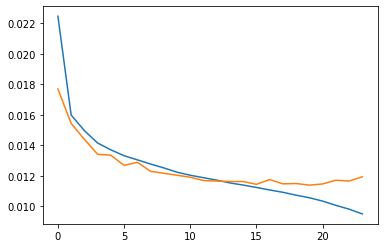

Current learning rate is: 0.001
===> Epoch[25](1/469): Loss: 0.0051 
===> Epoch[25](2/469): Loss: 0.0038 
===> Epoch[25](3/469): Loss: 0.0111 
===> Epoch[25](4/469): Loss: 0.0104 
===> Epoch[25](5/469): Loss: 0.0096 
===> Epoch[25](6/469): Loss: 0.0053 
===> Epoch[25](7/469): Loss: 0.0063 
===> Epoch[25](8/469): Loss: 0.0082 
===> Epoch[25](9/469): Loss: 0.0087 
===> Epoch[25](10/469): Loss: 0.0070 
===> Epoch[25](11/469): Loss: 0.0119 
===> Epoch[25](12/469): Loss: 0.0089 
===> Epoch[25](13/469): Loss: 0.0125 
===> Epoch[25](14/469): Loss: 0.0142 
===> Epoch[25](15/469): Loss: 0.0101 
===> Epoch[25](16/469): Loss: 0.0126 
===> Epoch[25](17/469): Loss: 0.0096 
===> Epoch[25](18/469): Loss: 0.0077 
===> Epoch[25](19/469): Loss: 0.0118 
===> Epoch[25](20/469): Loss: 0.0087 
===> Epoch[25](21/469): Loss: 0.0080 
===> Epoch[25](22/469): Loss: 0.0072 
===> Epoch[25](23/469): Loss: 0.0100 
===> Epoch[25](24/469): Loss: 0.0043 
===> Epoch[25](25/469): Loss: 0.0066 
===> Epoch[25](26/469): Los

===> Epoch[25](217/469): Loss: 0.0083 
===> Epoch[25](218/469): Loss: 0.0076 
===> Epoch[25](219/469): Loss: 0.0075 
===> Epoch[25](220/469): Loss: 0.0068 
===> Epoch[25](221/469): Loss: 0.0090 
===> Epoch[25](222/469): Loss: 0.0085 
===> Epoch[25](223/469): Loss: 0.0085 
===> Epoch[25](224/469): Loss: 0.0095 
===> Epoch[25](225/469): Loss: 0.0128 
===> Epoch[25](226/469): Loss: 0.0131 
===> Epoch[25](227/469): Loss: 0.0084 
===> Epoch[25](228/469): Loss: 0.0124 
===> Epoch[25](229/469): Loss: 0.0068 
===> Epoch[25](230/469): Loss: 0.0077 
===> Epoch[25](231/469): Loss: 0.0057 
===> Epoch[25](232/469): Loss: 0.0130 
===> Epoch[25](233/469): Loss: 0.0075 
===> Epoch[25](234/469): Loss: 0.0088 
===> Epoch[25](235/469): Loss: 0.0118 
===> Epoch[25](236/469): Loss: 0.0043 
===> Epoch[25](237/469): Loss: 0.0104 
===> Epoch[25](238/469): Loss: 0.0069 
===> Epoch[25](239/469): Loss: 0.0071 
===> Epoch[25](240/469): Loss: 0.0130 
===> Epoch[25](241/469): Loss: 0.0105 
===> Epoch[25](242/469): 

===> Epoch[25](428/469): Loss: 0.0123 
===> Epoch[25](429/469): Loss: 0.0140 
===> Epoch[25](430/469): Loss: 0.0050 
===> Epoch[25](431/469): Loss: 0.0052 
===> Epoch[25](432/469): Loss: 0.0095 
===> Epoch[25](433/469): Loss: 0.0101 
===> Epoch[25](434/469): Loss: 0.0087 
===> Epoch[25](435/469): Loss: 0.0100 
===> Epoch[25](436/469): Loss: 0.0115 
===> Epoch[25](437/469): Loss: 0.0090 
===> Epoch[25](438/469): Loss: 0.0124 
===> Epoch[25](439/469): Loss: 0.0144 
===> Epoch[25](440/469): Loss: 0.0058 
===> Epoch[25](441/469): Loss: 0.0072 
===> Epoch[25](442/469): Loss: 0.0070 
===> Epoch[25](443/469): Loss: 0.0104 
===> Epoch[25](444/469): Loss: 0.0110 
===> Epoch[25](445/469): Loss: 0.0116 
===> Epoch[25](446/469): Loss: 0.0090 
===> Epoch[25](447/469): Loss: 0.0068 
===> Epoch[25](448/469): Loss: 0.0087 
===> Epoch[25](449/469): Loss: 0.0081 
===> Epoch[25](450/469): Loss: 0.0082 
===> Epoch[25](451/469): Loss: 0.0106 
===> Epoch[25](452/469): Loss: 0.0099 
===> Epoch[25](453/469): 

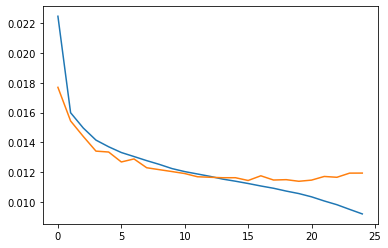

Current learning rate is: 0.001
===> Epoch[26](1/469): Loss: 0.0138 
===> Epoch[26](2/469): Loss: 0.0084 
===> Epoch[26](3/469): Loss: 0.0091 
===> Epoch[26](4/469): Loss: 0.0068 
===> Epoch[26](5/469): Loss: 0.0133 
===> Epoch[26](6/469): Loss: 0.0062 
===> Epoch[26](7/469): Loss: 0.0112 
===> Epoch[26](8/469): Loss: 0.0095 
===> Epoch[26](9/469): Loss: 0.0114 
===> Epoch[26](10/469): Loss: 0.0092 
===> Epoch[26](11/469): Loss: 0.0052 
===> Epoch[26](12/469): Loss: 0.0070 
===> Epoch[26](13/469): Loss: 0.0065 
===> Epoch[26](14/469): Loss: 0.0056 
===> Epoch[26](15/469): Loss: 0.0078 
===> Epoch[26](16/469): Loss: 0.0090 
===> Epoch[26](17/469): Loss: 0.0059 
===> Epoch[26](18/469): Loss: 0.0109 
===> Epoch[26](19/469): Loss: 0.0095 
===> Epoch[26](20/469): Loss: 0.0079 
===> Epoch[26](21/469): Loss: 0.0106 
===> Epoch[26](22/469): Loss: 0.0076 
===> Epoch[26](23/469): Loss: 0.0101 
===> Epoch[26](24/469): Loss: 0.0110 
===> Epoch[26](25/469): Loss: 0.0141 
===> Epoch[26](26/469): Los

KeyboardInterrupt: 

In [63]:
# Run the training procedure 
if  __name__ == "__main__":
    L = []
    L_val = []
    for epoch in range(1, nEpochs + 1):
        losses = train(epoch)
        L.append(np.mean(losses))
        losses_val = test()
        L_val.append(np.mean(losses_val))
        checkpoint(epoch)
        plt.plot(L)
        plt.plot(L_val)
        plt.show()
        for param_group in optimizer.param_groups:
                print("Current learning rate is: {}".format(param_group['lr']))
        
end = time.time()
print(end - start)

# Clean the memory

In [ ]:
del model

In [ ]:
import GPUtil
import gc
print(torch.cuda.memory_reserved())
print(torch.cuda.memory_allocated())
GPUtil.showUtilization()
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_reserved())
print(torch.cuda.memory_allocated())
GPUtil.showUtilization()